In [72]:
import pandas as pd
from io import StringIO
import os
from datetime import datetime, timedelta
import time  # Added import for delay
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Union, Set, Any
from enum import Enum
import pickle
import pandas as pd
import statsmodels.api as sm
import numpy as np
import logging
import unicodedata

from nst_scraper import nst_on_ice_scraper, nst_team_on_ice_scraper
from db_utils.nhl_db_utils import update_player_db, check_last_update, append_player_ids, get_player_full_name
from team_utils import get_most_recent_game_id, get_fullname_by_tricode
from game_utils import get_game_boxscore, display_boxscore
from pbp_utils import get_matchup_games
from db_utils.the_odds_db_utils import *

from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
np.set_printoptions(legacy='1.21')

Uses the_odds_db_utils to get player shots on goal odds


In [73]:
# player_stats_df = nst_on_ice_scraper(fromseason=20242025, thruseason=20242025, startdate='', enddate='', rate='y')
# player_stats_df.head()

In [74]:
# goalie_stats_df = nst_on_ice_scraper(fromseason=20242025, thruseason=20242025, startdate='', enddate='', pos='g', rate='y', stdoi='g')
# goalie_stats_df.head()

In [75]:
class Position(Enum):
    C = 'C'
    L = 'L'
    R = 'R'
    D = 'D'
    G = 'G'
    
    @property
    def category(self) -> str:
        if self in {Position.C, Position.L, Position.R}:
            return 'F'
        elif self == Position.D:
            return 'D'
        elif self == Position.G:
            return 'G'
    
    def __str__(self) -> str:
        return self.value

In [76]:
@dataclass
class Player:
    name: str
    team: str
    position: Position
    player_id: Optional[int] = None

    def __str__(self) -> str:
        """
        Returns a string representation of the player.
        """
        return f"{self.name} ({self.position}) - {self.team}"

    def to_dict(self) -> Dict[str, Optional[str]]:
        """
        Converts the Player instance into a dictionary.
        
        Returns:
            Dict[str, Optional[str]]: A dictionary representation of the player.
        """
        return {
            'player_id': self.player_id,
            'name': self.name,
            'team': self.team,
            'position': self.position.value
        }

In [77]:
@dataclass
class Lineup:
    name: str
    forwards: List[Optional[Player]] = field(default_factory=lambda: [None] * 12)
    defense: List[Optional[Player]] = field(default_factory=lambda: [None] * 6)
    goalies: List[Optional[Player]] = field(default_factory=lambda: [None] * 2)
    
    ALLOWED_FORWARD_CATEGORIES = {'F'}
    ALLOWED_DEFENSE_CATEGORY = 'D'
    ALLOWED_GOALIE_CATEGORY = 'G'
    
    def __post_init__(self):
        self.validate_lineup_size()
    
    def validate_lineup_size(self):
        total_players = sum(player is not None for player in self.forwards + self.defense + self.goalies)
        if total_players > 20:
            raise ValueError(f"Total number of players ({total_players}) exceeds the hard limit of 20.")
    
    def add_player(
        self,
        category: str,
        player: Player,
        slot: int,
        allowed_categories: Union[str, Set[str]],
        max_slots: int
    ):
        """
        Adds a player to the specified category and slot after validating their position category.
        Ensures that the total number of players does not exceed 20.
        """
        if isinstance(allowed_categories, str):
            allowed_categories = {allowed_categories}
        elif isinstance(allowed_categories, set):
            allowed_categories = allowed_categories
        else:
            raise TypeError("allowed_categories must be a string or a set of strings.")
        
        if player.position.category not in allowed_categories:
            raise ValueError(
                f"Cannot add player '{player.name}' with position '{player.position.value}' "
                f"to {category}. Allowed categories: {', '.join(allowed_categories)}."
            )
        
        if not 0 <= slot < max_slots:
            raise IndexError(f"{category.capitalize()} slot must be between 0 and {max_slots - 1}.")
        
        current_category = getattr(self, category)
        if current_category[slot]:
            existing_player = current_category[slot].name
            print(f"Warning: Slot {slot + 1} in {category} is already occupied by '{existing_player}'. Overwriting.")
        
        # Check total players before adding
        total_players = sum(player is not None for player in self.forwards + self.defense + self.goalies)
        if current_category[slot] is None and total_players >= 20:
            raise ValueError("Cannot add more players. The lineup has reached the hard limit of 20 players.")
        
        current_category[slot] = player
        setattr(self, category, current_category)
        print(f"Added player '{player.name}' to {category.capitalize()} slot {slot + 1}.")
    
    def add_forward(self, player: Player, slot: int):
        self.add_player(
            category='forwards',
            player=player,
            slot=slot,
            allowed_categories=self.ALLOWED_FORWARD_CATEGORIES,
            max_slots=len(self.forwards)
        )
    
    def add_defense(self, player: Player, slot: int):
        self.add_player(
            category='defense',
            player=player,
            slot=slot,
            allowed_categories={self.ALLOWED_DEFENSE_CATEGORY},
            max_slots=len(self.defense)
        )
    
    def set_goalie(self, player: Player, slot: int):
        self.add_player(
            category='goalies',
            player=player,
            slot=slot,
            allowed_categories={self.ALLOWED_GOALIE_CATEGORY},
            max_slots=len(self.goalies)
        )
    
    def adjust_slots(self, category: str, delta: int):
        """
        Adjusts the number of slots in the specified category by delta.
        Allows ±1 adjustment only.
        
        Args:
            category (str): The category to adjust ('forwards' or 'defense').
            delta (int): The change in number of slots (+1 or -1).
        """
        if category not in {'forwards', 'defense'}:
            raise ValueError("Can only adjust 'forwards' or 'defense' categories.")
        if delta not in {-1, 1}:
            raise ValueError("Delta must be either +1 or -1.")
        
        current_slots = getattr(self, category)
        new_slot_count = len(current_slots) + delta
        
        if category == 'forwards':
            if not (11 <= new_slot_count <= 13):
                raise ValueError("Number of forwards can only vary by ±1 from the default of 12.")
        elif category == 'defense':
            if not (5 <= new_slot_count <= 7):
                raise ValueError("Number of defensemen can only vary by ±1 from the default of 6.")
        
        if delta == 1:
            current_slots.append(None)
        elif delta == -1:
            removed_player = current_slots.pop()
            if removed_player:
                print(f"Removed player '{removed_player.name}' from {category}.")
        
        setattr(self, category, current_slots)
        print(f"Adjusted {category} slots to {len(getattr(self, category))}.")
        self.validate_lineup_size()
    
    def display_lineup(self):
        """
        Prints the current lineup in a structured format.
        """
        print(f"Lineup: {self.name}\n")
        
        for category, title in [('forwards', 'Forwards'), ('defense', 'Defense'), ('goalies', 'Goalies')]:
            print(f"{title}:")
            for idx, player in enumerate(getattr(self, category), start=1):
                player_info = str(player) if player else 'Empty'
                print(f"  Slot {idx}: {player_info}")
            print()
    
    def to_dataframe(self) -> pd.DataFrame:
        """
        Converts the lineup into a pandas DataFrame.
        Conditionally includes player attributes if they are present.
        """
        data = []
        for category, pos in [('forwards', 'f'), ('defense', 'd'), ('goalies', 'g')]:
            for idx, player in enumerate(getattr(self, category), start=1):
                player_dict = {
                    'Position': f"{pos}{idx}",
                    'Player': player.name if player else 'Empty'
                }
                # Conditionally add 'player_id' if it exists
                if player and player.player_id is not None:
                    player_dict['Player ID'] = player.player_id
                data.append(player_dict)
        
        df = pd.DataFrame(data)
        
        # Optionally, remove columns where all values are NaN
        df.dropna(axis=1, how='all', inplace=True)
        
        return df
    
    def to_transposed_dataframe(self) -> pd.DataFrame:
        """
        Transposes the lineup DataFrame so that each column represents a position-slot combination
        and the row contains the corresponding player names.
        Conditionally includes additional player attributes if they are present.
        """
        df = self.to_dataframe()
        
        # Initialize dictionaries to hold player names and optional IDs
        player_data = {}
        id_data = {}
        
        for _, row in df.iterrows():
            pos = row['Position']
            player_name = row['Player']
            player_data[pos] = player_name
            
            # Handle 'Player ID' if it exists
            if 'Player ID' in row and pd.notna(row['Player ID']):
                id_data[f"{pos}_ID"] = row['Player ID']
        
        # Combine player names and IDs into a single dictionary
        transposed_data = {**player_data, **id_data}
        
        # Create the transposed DataFrame with a single row
        transposed_df = pd.DataFrame([transposed_data])
        
        return transposed_df

In [78]:
today_datetime= datetime.now()
yesterday_datetime = today_datetime - timedelta(days=1, hours=6) # UTC offset
yesterday = yesterday_datetime.strftime('%Y-%m-%d')
yesterday

'2025-01-05'

In [79]:
# Load environment variables from .env file
load_dotenv()

db_prefix = 'NHL_DB_'

# Check the last update time of the players database
last_update = check_last_update(db_prefix)

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Last database update was on: 2025-01-06
INFO:db_utils.base_utils:Database connection closed.


In [80]:
# Convert last_update to datetime
last_update_dt = datetime.strptime(last_update, '%Y-%m-%d')
today_dt = datetime.strptime(today_datetime.strftime('%Y-%m-%d'), '%Y-%m-%d')
yesterday_dt = datetime.strptime(yesterday, '%Y-%m-%d')

# Only update if last update was before yesterday
if last_update_dt not in [today_dt, yesterday_dt]:
    # Update the player database from last update to yesterday
    update_player_db(last_update, yesterday, db_prefix, skip_existing=True)
else:
    print(f"No need to update the player database. Last update was on: {last_update}")


No need to update the player database. Last update was on: 2025-01-06


In [81]:
def add_player_to_lineup(lineup: Lineup, player: Player, category: str):
    """
    Adds a player to the lineup in the specified category, handling potential errors.
    
    Args:
        lineup (Lineup): The lineup object.
        player (Player): The player to add.
        category (str): The category ('forwards', 'defense', 'goalies').
    """
    try:
        if category == 'forwards':
            slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
            lineup.add_forward(player, slot)
        elif category == 'defense':
            slot = next(i for i, p in enumerate(lineup.defense) if p is None)
            lineup.add_defense(player, slot)
        elif category == 'goalies':
            slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, slot)
        else:
            print(f"Unknown category '{category}'.")
    except StopIteration:
        print(f"No available slots to add player '{player.name}' in category '{category}'.")
    except ValueError as ve:
        print(ve)
    except IndexError as ie:
        print(ie)

In [82]:
def get_skater_stats(lineup: Lineup, player_stats_df: pd.DataFrame, filter: Optional[str] = None) -> pd.DataFrame:
    """
    Gets stats for players in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing players
        player_stats_df (pd.DataFrame): DataFrame with player statistics
        filter (str, optional): Type of filter to apply on the stats.
            Defaults to None, which keeps all stats. If 'shots', only shot-related statistics are kept.
        
    Returns:
        pd.DataFrame: Player statistics ordered according to lineup positions
    """
    # Apply filter if specified
    if filter == 'shots':
        # Define shot-related columns to keep
        shot_columns = ['player', 'team', 'position', 'gp', 'toi', 'toi/gp','shots/60', 'icf/60', 'iff/60'] 
        player_stats_df = player_stats_df[shot_columns]
    
    # Create ordered list of players (forwards then defense)
    players = []
    # Add forwards in order
    players.extend([p for p in lineup.forwards if p])
    # Add defense in order 
    players.extend([p for p in lineup.defense if p])
    
    # Create ordered list of player names
    player_names = [player.name for player in players]
    
    # Filter stats and reorder to match lineup order
    stats_df = player_stats_df[player_stats_df['player'].isin(player_names)]
    
    # Ensure all players are from the same team
    team_codes = stats_df['team'].unique()
    if len(team_codes) > 1:
        # Assuming lineup is for a single team, get the team from the first player in the lineup
        team_code = None
        for player in lineup.forwards + lineup.defense + lineup.goalies:
            if player:
                team_code = player.team
                break
        if team_code:
            stats_df = stats_df[stats_df['team'] == team_code]
        else:
            raise ValueError("No players found in lineup to determine team.")
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(player_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

# lineup_player_stats = get_skater_stats(my_lineup, player_stats_df)

In [83]:
def get_goalie_stats(lineup: Lineup, goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing goalies
        goalie_stats_df (pd.DataFrame): DataFrame with goalie statistics
        
    Returns:
        pd.DataFrame: Goalie statistics ordered according to lineup positions
    """
    # Create ordered list of goalies
    goalies = [goalie for goalie in lineup.goalies if goalie]
    goalie_names = [goalie.name for goalie in goalies]
    
    # Filter stats and reorder to match lineup order
    stats_df = goalie_stats_df[goalie_stats_df['player'].isin(goalie_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(goalie_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

In [84]:
def extract_team_lineup(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Extracts the most recent lineup for the specified team based on the latest game data.

    This function performs the following steps:
        1. Determines the reference date (defaults to yesterday if not provided).
        2. Retrieves the most recent game ID for the team using `get_most_recent_game_id`.
        3. Fetches the game boxscore data using `get_game_boxscore`.
        4. Processes the boxscore to obtain skaters and goalies using `display_boxscore`.
        5. Constructs and returns a `Lineup` object populated with the team's players.

    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.

    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.

    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbrevs to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")

    # Add Skaters to the Lineup
    for _, skater in skaters.iterrows():
        try:
            position_enum = Position(skater['position'])  # Convert to Position Enum
        except ValueError:
            print(f"Invalid position '{skater['position']}' for player '{skater['name']}'. Skipping.")
            continue

        player = Player(
            player_id=skater['playerId'],
            name=get_player_full_name(skater['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=position_enum
        )

        # Add player to the appropriate category in the lineup
        if player.position.category == 'F':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
                lineup.add_forward(player, empty_slot)
            except StopIteration:
                print(f"No available forward slot to add player '{player.name}'.")
        elif player.position.category == 'D':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.defense) if p is None)
                lineup.add_defense(player, empty_slot)
            except StopIteration:
                print(f"No available defense slot to add player '{player.name}'.")
        else:
            print(f"Player '{player.name}' has an unrecognized category '{player.position.category}'. Skipping.")

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# chicago_lineup = extract_team_lineup('CHI', '2024-11-22')

In [85]:
def calculate_min_percentage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average time on ice per game as a percentage of total game time (60 minutes).
    
    Args:
        df (pd.DataFrame): DataFrame containing 'toi' and 'gp' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'min%' column added
    """
    df_copy = df.copy()
    df_copy['min%'] = (df_copy['toi'] / df_copy['gp'] / 300 * 100).round(2)
    return df_copy

# # Apply the function to lineup_player_stats
# lineup_player_stats = calculate_min_percentage(lineup_player_stats)
# lineup_player_stats

In [86]:
def sum_min_percentage(df: pd.DataFrame) -> float:
    """
    Calculates the sum of the 'min%' column in the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        
    Returns:
        float: The total sum of the 'min%' values.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    total_min_percentage = df['min%'].sum()
    return total_min_percentage

# Example usage:
# total_min_percentage = sum_min_percentage(lineup_player_stats)
# print(f"Total min%: {total_min_percentage}")

In [87]:
def calculate_adj_min(df: pd.DataFrame, total_min_percentage: float) -> None:
    """
    Calculates the adjusted minimum (adj_min) for each player based on their min% and the total min%.
    
    The formula used is:
        adj_min = (min% / total_min_percentage) * 300
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        total_min_percentage (float): The total sum of the 'min%' column.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
        ValueError: If total_min_percentage is not a positive number.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    if total_min_percentage <= 0:
        raise ValueError("total_min_percentage must be a positive number.")
    
    # Calculate and append the 'adj_min' column
    df['adj_min'] = ((df['min%'] / total_min_percentage) * 300).round(2)

# # Example usage:
# calculate_adj_min(lineup_player_stats, total_min_percentage)
# print(lineup_player_stats[['player', 'min%', 'adj_min']])

In [88]:
# Define file paths to load the model and transformer
model_filepath = 'models/polynomial_model_degree_1.pkl'
poly_filepath = 'models/polynomial_features_degree_1.pkl'

# Load the regression model
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print(f"Model loaded from {model_filepath}")

# Load the PolynomialFeatures transformer
with open(poly_filepath, 'rb') as poly_file:
    loaded_poly = pickle.load(poly_file)
print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

# Function to make predictions using the loaded model and transformer
def predict_gpm(new_ixg60_value, model, poly, x_col='ixg60'):
    """
    Predicts 'gpm' using the loaded model and polynomial transformer.
    
    Parameters:
        new_ixg60_value (float): The new ixg60 value for prediction.
        model (RegressionResults): The loaded regression model.
        poly (PolynomialFeatures): The loaded polynomial features transformer.
        x_col (str): The name of the independent variable column. Defaults to 'ixg60'.
        
    Returns:
        predicted_gpm (float): The predicted gpm value.
    """
    # Prepare the input data
    X_new = np.array([[new_ixg60_value]])
    X_new_poly = poly.transform(X_new)
    X_new_poly_const = sm.add_constant(X_new_poly, has_constant='add')
    
    # Create DataFrame with appropriate column names
    feature_names = ['const'] + poly.get_feature_names_out([x_col]).tolist()
    new_data = pd.DataFrame(X_new_poly_const, columns=feature_names)
    
    # Predict
    predicted_gpm = model.predict(new_data)
    return predicted_gpm.iloc[0]

# Example: Predicting 'gpm' for a new ixg60 value
# new_ixg60_value = 50
# predicted_gpm = predict_gpm(new_ixg60_value, loaded_model, loaded_poly)
# print(f"Predicted GPM for ixg60={new_ixg60_value}: {predicted_gpm:.4f}")

Model loaded from models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from models/polynomial_features_degree_1.pkl


In [89]:
# Function to predict GPM for each player and add it to the DataFrame
def add_gpm_to_lineup(lineup_df, model, poly):
    """
    Adds a 'gpm' column to the lineup_player_stats DataFrame using the predict_gpm function.
    
    Args:
        lineup_df (pd.DataFrame): DataFrame containing 'ixg/60' column.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with 'gpm' column added.
    """
    # Define a helper function to handle potential missing or invalid values
    def safe_predict(ixg_60):
        if pd.isna(ixg_60):
            return np.nan
        try:
            return predict_gpm(ixg_60, model, poly)
        except Exception as e:
            print(f"Error predicting GPM for ixg_60={ixg_60}: {e}")
            return np.nan
    
    # Apply the predict_gpm function to each 'ixg/60' value
    lineup_df['gpm'] = lineup_df['ixg/60'].apply(safe_predict)
    return lineup_df

# # Apply the function to add 'gpm' to your DataFrame
# lineup_player_stats = add_gpm_to_lineup(lineup_player_stats, loaded_model, loaded_poly)

# # Display the updated DataFrame with 'gpm'
# print(lineup_player_stats[['player', 'ixg/60', 'gpm']])

In [90]:
def calculate_x_goals(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_goals' by multiplying 'gpm' with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'gpm' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'gpm' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'gpm' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'gpm', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'gpm' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['gpm']):
        raise TypeError("'gpm' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_goals'
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_goals'] = lineup_stats_df['gpm'] * lineup_stats_df['adj_min']
    
    return lineup_stats_df

In [91]:
def calculate_league_avg_xg_against_per_60(goalie_stats_df: pd.DataFrame) -> float:
    """
    Calculate the league average expected goals against (xg_against) per 60 minutes.

    Args:
        goalie_stats_df (pd.DataFrame): DataFrame containing goalie statistics with 'xg_against' and 'toi' columns.

    Returns:
        float: The league average xg_against per 60 minutes.

    Raises:
        KeyError: If required columns are missing from the DataFrame.
        ValueError: If no valid goalies with non-zero 'toi' are found.
    """
    # Ensure required columns are present
    required_columns = {'xg_against', 'toi'}
    missing_columns = required_columns - set(goalie_stats_df.columns)
    if missing_columns:
        raise KeyError(f"Missing columns in goalie_stats_df: {', '.join(missing_columns)}")

    # Drop rows with missing or zero 'toi' to avoid division errors
    valid_goalies = goalie_stats_df.dropna(subset=['xg_against', 'toi'])
    valid_goalies = valid_goalies[valid_goalies['toi'] > 0]

    if valid_goalies.empty:
        raise ValueError("No valid goalies with non-zero 'toi' found in goalie_stats_df.")

    # Calculate xg against per 60 minutes for each goalie
    valid_goalies['xg_against_per_60'] = (valid_goalies['xg_against'] / valid_goalies['toi']) * 60

    # Calculate the league average
    league_avg_xg_against_per_60 = valid_goalies['xg_against_per_60'].mean()

    return league_avg_xg_against_per_60

In [92]:
def calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60):
    """
    Calculate the expected goals against adjusted percentage.
    """
    lineup_goalie_stats['adj%'] = (lineup_goalie_stats['xg_against/60'] / goalie_avg_xg_against_per_60) * 100
    return lineup_goalie_stats

In [93]:
def load_models(model_filepath='models/polynomial_model_degree_1.pkl',
               poly_filepath='models/polynomial_features_degree_1.pkl'):
    """
    Loads the regression model and PolynomialFeatures transformer from the specified file paths.

    Args:
        model_filepath (str): Path to the saved regression model pickle file.
        poly_filepath (str): Path to the saved PolynomialFeatures transformer pickle file.

    Returns:
        tuple: A tuple containing the loaded regression model and PolynomialFeatures transformer.

    Raises:
        FileNotFoundError: If either of the specified files does not exist.
        pickle.UnpicklingError: If there is an error unpickling the files.
    """
    try:
        # Load the regression model
        with open(model_filepath, 'rb') as model_file:
            loaded_model = pickle.load(model_file)
        print(f"Model loaded from {model_filepath}")

        # Load the PolynomialFeatures transformer
        with open(poly_filepath, 'rb') as poly_file:
            loaded_poly = pickle.load(poly_file)
        print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

        return loaded_model, loaded_poly

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
        raise
    except pickle.UnpicklingError as pickle_error:
        print(f"Error loading pickle files: {pickle_error}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

In [94]:
# Load the models using the new function
loaded_model, loaded_poly = load_models()

Model loaded from models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from models/polynomial_features_degree_1.pkl


In [95]:
def calculate_x_shots(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_shots' by multiplying 'shots/60' divided by 60 with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'shots/60' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'shots/60' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'shots/60' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'shots/60', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'shots/60' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['shots/60']):
        raise TypeError("'shots/60' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_shots' formatted to 2 decimal points
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_shots'] = ((lineup_stats_df['shots/60'] / 60) * lineup_stats_df['adj_min']).round(2)
    
    return lineup_stats_df

In [96]:
def process_team_lineup_shots(input_date: str, team: str, player_stats_df: pd.DataFrame=None) -> pd.DataFrame:
    """
    Processes the team's lineup for a given date and predicts shots for each player.

    This function performs the following steps:
        1. Calls `nst_on_ice_scraper` for the input date minus one day to retrieve player and goalie statistics.
        2. Extracts the team's lineup using `extract_team_lineup`.
        3. Retrieves skater statistics with `get_skater_stats`, filtering by 'shots'.
        4. Calculates `min%` using `calculate_min_percentage`.
        5. Computes `adj_min` using `calculate_adj_min` based on total min%.
        6. Calculates `x_shots` by multiplying 'shots/60' by `adj_min`.

    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
        player_stats_df (pd.DataFrame, optional): DataFrame containing player statistics. Defaults to None.

    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and predicted shots (`x_shots`).

    Raises:
        ValueError: If any step in the data processing pipeline fails.
    """

    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 2: Call nst_on_ice_scraper for player and goalie stats
        if player_stats_df is None or player_stats_df.empty:
            player_stats_df = nst_on_ice_scraper(
                fromseason=20242025,
                thruseason=20242025,
                startdate='',
                enddate=reference_date_str,
                rate='y'
            )
            print("Player and goalie statistics fetched successfully.")
        else:
            print("Player and goalie statistics already provided.")

        # Step 3: Extract team lineup for the input date and team
        lineup = extract_team_lineup(team, input_date)
        print(f"Lineup extracted for team {team} on {input_date}.")

        # Step 4: Get skater statistics for the lineup
        lineup_skater_stats = get_skater_stats(lineup, player_stats_df, filter='shots')

        # Step 5: Calculate min%
        lineup_skater_stats = calculate_min_percentage(lineup_skater_stats)

        # Step 6: Calculate adj_min
        total_min_percentage = sum_min_percentage(lineup_skater_stats)
        calculate_adj_min(lineup_skater_stats, total_min_percentage)

        # Step 7: Calculate x_shots
        lineup_skater_stats = calculate_x_shots(lineup_skater_stats)
        
        return lineup_skater_stats

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# shots = process_team_lineup_shots('2024-12-09', 'NYR')
# shots

In [97]:
def process_team_shots_and_opponent(input_date: str, team: str, player_stats_df: pd.DataFrame=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Processes a team's lineup shots and retrieves opponent's on-ice statistics for a given date.
    
    This function performs the following steps:
        1. Runs `process_team_lineup_shots` for the specified team and date.
        2. Retrieves the game_id where the team played on the specified date.
        3. Identifies the opponent team based on the game_id.
        4. Converts the opponent team's triCode to its full name.
        5. Uses `nst_team_on_ice_scraper` to fetch the opponent team's on-ice statistics.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
    
    Returns:
        Dict[str, Any]: A dictionary containing the team's lineup shots DataFrame, game_id, opponent team code,
                        and opponent's on-ice statistics DataFrame.
    
    Raises:
        ValueError: If the team did not play on the specified date or if the opponent cannot be determined.
    """
    try:
        # Step 1: Determine the reference date, if input_date is None, use yesterday's date
        if input_date is None:
            today_datetime = datetime.now()
            yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
            input_date = yesterday_datetime.strftime('%Y-%m-%d')
        else:
            input_datetime = datetime.strptime(input_date, '%Y-%m-%d')
            day_before_input_dt = input_datetime - timedelta(days=1, hours=6)
            day_before_input = day_before_input_dt.strftime('%Y-%m-%d')

        # Step 2: Run process_team_lineup_shots for the given team and date
        team_shots_df = process_team_lineup_shots(input_date, team, player_stats_df)
        
        # Insert date as the first column
        team_shots_df.insert(0, 'date', input_date)
        
        print(f"Processed lineup shots for team {team} on {input_date}.")

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None

        # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")

        # Start of Selection
        # Step 5: Convert opponent_team_tricode to full name and remove accent marks
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)
        if opponent_team_fullname is None:
            raise ValueError(f"Could not find full name for opponent TriCode '{opponent_team_tricode}'.")
        
        # Remove any accent marks and punctuation from opponent_team_fullname
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
            )
        print(f"Opponent Team Full Name: {opponent_team_fullname}")
        
        # Assuming 'team' is the column name for team full names in the scraped DataFrame
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in opponent_stats_df. Please verify the scraped data.")

        team_stats_df = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        if team_stats_df.empty:
            raise ValueError(f"No on-ice statistics found for opponent team '{opponent_team_fullname}'.")
        print(f"Retrieved on-ice statistics for opponent team {opponent_team_fullname}.")

        # Step 7: Extract opponent's Corsi For Percentage (CF%)
        # Assuming the column name for CF% is 'cf%'. Adjust if different.
        if 'cf%' not in team_stats_df.columns:
            raise KeyError("Column 'cf%' not found in opponent_stats_df. Please verify the scraped data.")

        opponent_cf_pct = team_stats_df['cf%'].iloc[0]
        print(f"Opponent's Corsi For Percentage (CF%): {opponent_cf_pct}")

        # Step 8: Apply CF% as a modifier to the team's projected shots (x_shots) using a 50% baseline
        baseline_cf_pct = 50  # Baseline CF% (average value)

        # Adjust x_shots based on opponent's CF%
        team_shots_df['x_shots_mod'] = (team_shots_df['x_shots'] * (baseline_cf_pct / opponent_cf_pct)).round(2)
        print("Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.")

        return {
            'team_shots': team_shots_df,
            'game_id': game_id,
            'opponent_team': opponent_team_fullname,
            'opponent_stats': team_stats_df
        }

    except Exception as e:
        print(f"An error occurred during processing: {e}")

# # Example usage of the process_team_and_opponent function
# input_date = '2024-12-10'
# team = 'COL'  # Example team code
# matchup_data = process_team_shots_and_opponent(input_date, team)

# # Accessing the data
# team_shots = matchup_data['team_shots']
# game_id = matchup_data['game_id']
# opponent_team = matchup_data['opponent_team']
# opponent_stats = matchup_data['opponent_stats']

In [98]:
def add_sog_to_team_shots(team_shots_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds shots on goal data to the team_shots DataFrame by parsing boxscores for each unique date and team.

    This function performs the following steps:
        1. Identifies unique combinations of 'date' and 'team' in the team_shots_df.
        2. For each unique combination, retrieves the most recent game_id using `get_most_recent_game_id`.
        3. Retrieves and processes the boxscore for each game_id using `display_boxscore` with `clean=False`.
        4. Extracts player-specific shots on goal from the processed boxscore.
        5. Merges the shots on goal data back into the original team_shots_df.

    Args:
        team_shots_df (pd.DataFrame): DataFrame containing at least 'date', 'team', and 'player' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with an additional 'shots_on_goal' column.

    Raises:
        KeyError: If required columns are missing in the team_shots_df.
        Exception: For any unexpected errors during processing.
    """

    # Ensure required columns are present
    required_columns = {'date', 'team', 'player'}
    if not required_columns.issubset(team_shots_df.columns):
        missing = required_columns - set(team_shots_df.columns)
        raise KeyError(f"Missing required columns in team_shots_df: {', '.join(missing)}")

    # Find unique date and team combinations
    unique_combinations = team_shots_df[['date', 'team']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        game_date = row['date']
        team = row['team']

        try:
            # Retrieve the most recent game_id for the team on the given date
            game_id = get_most_recent_game_id(team, game_date)
            if game_id is None:
                print(f"No game found for team {team} on {game_date}.")
            else:
                # Retrieve and process the boxscore using display_boxscore with clean=False
                processed_boxscore = display_boxscore(game_id)

                # processed_boxscore is a tuple of 4 dataframes
                away_skaters = processed_boxscore[0]
                home_skaters = processed_boxscore[2]

                # Extract team abbreviations from skaters DataFrames
                # Assuming each skaters DataFrame has a 'team_abbrev' column
                away_team_abbrev = away_skaters['team_abbrev'].iloc[0] if not away_skaters.empty else None
                home_team_abbrev = home_skaters['team_abbrev'].iloc[0] if not home_skaters.empty else None

                if team.upper() == away_team_abbrev.upper():
                    # Add full names to away_skaters
                    away_skaters['full_name'] = away_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    
                    # Merge to get player-specific shots
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        away_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    
                    # Assign the 'shots_on_goal' from 'sog', handle missing values
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                elif team.upper() == home_team_abbrev.upper():
                    # Add full names to home_skaters
                    home_skaters['full_name'] = home_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    
                    # Merge to get player-specific shots
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        home_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    
                    # Assign the 'sog' from 'sog', handle missing values
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                else:
                    print(f"Team {team} does not match away ({away_team_abbrev}) or home ({home_team_abbrev}) team abbreviations.")
                    # sog = None
                    # Optionally, you can choose to assign None or another value
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = None

        except Exception as e:
            print(f"Error processing team {team} on date {game_date}: {e}")
            # Assign None to 'sog' in case of an error
            team_shots_df.loc[
                (team_shots_df['date'] == game_date) &
                (team_shots_df['team'] == team),
                'sog'
            ] = None

    return team_shots_df

# example usage
# team_shots = add_sog_to_team_shots(team_shots)

In [99]:
def process_team_shots(team_shots_df, sportsbook, line=True):
    """
    Process all players in team_shots DataFrame to retrieve their shot over/under odds and prepare data for merging.
    
    Each player will appear only once in the returned DataFrame, with separate columns for over_odds, under_odds,
    and handicap, provided that the handicap for both bets is equal.
    
    Args:
        team_shots_df (pd.DataFrame): DataFrame containing player shot data with columns:
            date, player, team, position, gp, toi, toi/gp, shots/60, etc.
        sportsbook (str): The name of the sportsbook to filter odds by.
        line (bool, optional): If True, filters odds to find those closest to +100. Defaults to True.
    
    Returns:
        pd.DataFrame: A DataFrame with player names, their respective over_odds, under_odds, and handicap,
                      ready to be merged with team_shots_df.
    
    Raises:
        KeyError: If required columns are missing in team_shots_df.
        ValueError: If multiple dates are present in team_shots_df.
    """
    # Ensure that 'date' and 'team' columns exist
    if 'date' not in team_shots_df.columns or 'team' not in team_shots_df.columns:
        raise KeyError("The DataFrame must contain 'date' and 'team' columns.")
    
    # Get the unique date(s) from the DataFrame
    unique_dates = team_shots_df['date'].unique()
    if len(unique_dates) != 1:
        raise ValueError("All players in the DataFrame must have the same 'date'.")
    
    query_date = unique_dates[0]
    
    # Get unique players and their teams from the DataFrame
    players = team_shots_df[['player', 'team']].drop_duplicates()
    
    # Initialize a list to collect odds data
    team_odds = []
    
    for _, row in players.iterrows():
        player = row['player']
        team_abbrev = row['team']
        team_fullname = ''.join(
            c for c in get_fullname_by_tricode(team_abbrev)
            if not unicodedata.category(c).startswith('P') and (c.isalnum() or c.isspace())
        )
        
        if not team_fullname:
            logging.warning(f"Could not find full name for team abbreviation '{team_abbrev}'. Skipping player '{player}'.")
            continue
        
        logging.info(f"Processing player: {player} from team: {team_fullname}")
        
        odds_list = get_player_sog_odds(
            player_name=player,
            team_name=team_fullname,  # Pass the full team name
            query_date=query_date, 
            sportsbook=sportsbook,
            line=line
        )
        
        if odds_list:
            # Initialize dictionaries to hold Over and Under odds
            player_odds = {'player': player}
            handicap_set = set()
            handicap_value = None  # Initialize handicap_value
            
            for odds in odds_list:
                # Remove 'game_id' from odds if it exists
                odds_cleaned = {k: v for k, v in odds.items() if k != 'game_id'}
                
                # Collect handicap values to ensure they are equal
                handicap = odds_cleaned.get('handicap')
                handicap_set.add(handicap)
                
                # Update keys to match new format
                market_type = odds_cleaned.get('market_type')
                odds_value = odds_cleaned.get('price')
                
                if market_type and odds_value is not None:
                    if market_type.lower() == 'over':
                        player_odds['over_odds'] = odds_value
                    elif market_type.lower() == 'under':
                        player_odds['under_odds'] = odds_value
            
            # Check if handicaps are equal
            if len(handicap_set) > 1:
                logging.warning(f"Handicaps for player '{player}' are not equal: {handicap_set}. Skipping player.")
                continue  # Skip this player due to unequal handicaps
            elif len(handicap_set) == 1:
                handicap_value = handicap_set.pop()
                player_odds['handicap'] = handicap_value  # Add handicap to player_odds
            else:
                logging.warning(f"No handicap information found for player '{player}'. Skipping player.")
                continue  # Skip if no handicap information
            
            team_odds.append(player_odds)
            logging.info(f"Retrieved and cleaned odds for {player}.")
        else:
            logging.warning(f"No odds found for {player}.")
    
    # Define the desired column order
    column_order = ['player', 'handicap', 'over_odds', 'under_odds']
    
    # Convert the list of odds dictionaries to a DataFrame with specified column order
    if team_odds:
        odds_df = pd.DataFrame(team_odds, columns=column_order)
    else:
        odds_df = pd.DataFrame(columns=column_order)
    
    return odds_df

In [100]:
# Retrieve odds DataFrame
# odds_df = process_team_shots(team_shots, sportsbook='draftkings', line=True)

# Display the retrieved odds
# print(odds_df)

In [101]:
# Merge the odds into team_shots_df. Since each player has only one row in odds_df, a simple left join suffices
# merged_df = pd.merge(team_shots, odds_df, on='player', how='left')

# Display the merged DataFrame
# merged_df

In [102]:
def process_date_shots(date: str, sportsbook: str = 'draftkings') -> pd.DataFrame:
    """
    Processes team shots for all games on a given date by retrieving game IDs,
    extracting team information, processing shot data and opponent statistics,
    merging odds into the shot data, and compiling the results into a single DataFrame.
    
    This function performs the following steps:
        1. Retrieves the game IDs for the specified date using `get_matchup_games`.
        2. Calls `nst_on_ice_scraper` to fetch player and goalie statistics.
        3. Extracts the teams involved in each game using `get_game_boxscore` with `clean=True`.
        4. For each team in each game, processes their shots and opponent's on-ice statistics using `process_team_shots_and_opponent`.
        5. Processes the team shots to retrieve odds using `process_team_shots`.
        6. Merges the odds into the team shots DataFrame.
        7. Appends all processed and merged results into a single DataFrame.
    
    Args:
        date (str): The reference date in 'YYYY-MM-DD' format.
        sportsbook (str): The name of the sportsbook to filter odds by. Defaults to 'draftkings'.
    
    Returns:
        pd.DataFrame: A concatenated DataFrame containing processed shot data for all teams
                      across all games on the specified date. The DataFrame excludes 'game_id'
                      and 'opponent_team' columns.
    
    Raises:
        ValueError: If no games are found on the specified date or if no team shot data is processed.
    """
    logging.info(f"Starting processing for date: {date}")
    
    # Step 1: Retrieve matchup games for the given date
    matchup = get_matchup_games(start_date=date, end_date=date)
    game_ids = matchup.get('game_ids', {}).get('id', [])
    
    # Step 2: Call nst_on_ice_scraper for player and goalie stats
    reference_datetime = datetime.strptime(date, '%Y-%m-%d') - timedelta(days=1)
    reference_date_str = reference_datetime.strftime('%Y-%m-%d')
    
    player_stats_df = None  # Initialize player_stats_df
    player_stats_df = nst_on_ice_scraper(
        fromseason=20242025,
        thruseason=20242025,
        startdate='',
        enddate=reference_date_str,
        rate='y'
    )
    print("Player and goalie statistics fetched successfully.")

    team_stats_df = None # Initialize
    team_stats_df = nst_team_on_ice_scraper(
        fromseason=20242025,
        thruseason=20242025,
        startdate='',
        enddate=reference_date_str,
        stype=2,
        sit='all'
    )
    if not game_ids:
        error_msg = f"No games found on date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    results = []
    
    # Step 3: Iterate through each game to extract team information
    for game_id in game_ids:
        logging.info(f"Processing game ID: {game_id}")
        boxscore = get_game_boxscore(game_id, clean=True)
        away_team = boxscore.get('away_team')
        home_team = boxscore.get('home_team')
        
        if not away_team or not home_team:
            logging.warning(f"Missing team information for game ID {game_id}. Skipping this game.")
            continue  # Skip this game if team information is incomplete
        
        # List of teams in the current game
        teams = [away_team, home_team]
        
        for team in teams:
            try:
                logging.info(f"Processing team: {team} in game ID: {game_id}")
                
                # Step 4: Process team shots and opponent statistics
                processed_data = process_team_shots_and_opponent(date, team, player_stats_df, team_stats_df)
                
                # Extract the team_shots DataFrame from the processed data
                team_shots_df = processed_data.get('team_shots')
                
                if team_shots_df is None or team_shots_df.empty:
                    logging.warning(f"No shot data found for team {team} on {date}. Skipping this team.")
                    continue  # Skip processing if no shot data is available

                # Step 5: Add sog (actual shots on goal) to the team_shots DataFrame
                team_shots_df = add_sog_to_team_shots(team_shots_df)

                # Step 6: Process the team shots DataFrame to retrieve odds
                #TODO need to add either error saying no odds retrieved, or fetch the odds
                processed_shots_df = process_team_shots(team_shots_df, sportsbook, line=True)
                
                if processed_shots_df.empty:
                    logging.warning(f"Processed shot data is empty for team {team} on {date}. Skipping this team.")
                    continue  # Skip appending if processing yields no data
                
                # Step 7: Merge the odds into the team_shots DataFrame
                merged_df = pd.merge(team_shots_df, processed_shots_df, on='player', how='left')
                
                # Optional: Add team information if not already present
                if 'team' not in merged_df.columns:
                    merged_df['team'] = team
                
                # Step 8: Append the merged DataFrame to the results list
                results.append(merged_df)
                logging.info(f"Successfully processed and merged data for team {team} in game ID {game_id}.")
            
            except Exception as e:
                # Handle exceptions for individual teams to prevent entire function from failing
                logging.error(f"Error processing team '{team}' in game '{game_id}': {e}")
                continue  # Proceed to the next team
    
    if results:
        # Step 9: Concatenate all individual DataFrames into a single DataFrame
        final_df = pd.concat(results, ignore_index=True)
        logging.info("Successfully concatenated all processed and merged team shot data.")
        
        # Step 10: Ensure 'game_id' and 'opponent_team' columns are excluded
        columns_to_exclude = ['game_id', 'opponent_team']
        existing_columns_to_exclude = [col for col in columns_to_exclude if col in final_df.columns]
        
        if existing_columns_to_exclude:
            final_df = final_df.drop(columns=existing_columns_to_exclude)
            logging.info(f"Excluded columns: {existing_columns_to_exclude} from the final DataFrame.")
        
        logging.info("Processing completed successfully.")
        return final_df
    else:
        error_msg = f"No team shot data processed for date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)

In [103]:
shots_123124_df = process_date_shots(date='2024-12-31', sportsbook='fanduel')

INFO:root:Starting processing for date: 2024-12-31


Player and goalie statistics fetched successfully.


INFO:root:Processing game ID: 2024020589
INFO:root:Processing team: BOS in game ID: 2024020589


Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020570
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'Fabian Lysell' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Parker Wotherspoon' to Defense slot 3.
Added player 'Andrew Peeke' to Defense slot 4.
Added player 'Charlie McAvoy' to Defense slot 5.
Added player 'Nikita Zadorov' to Defense slot 6.
Ad

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Trent Frederic' for player_id 8479365.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Charlie Coyle' for player_id 8475745.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Pavel Zacha' for player_id 8478401.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Fabian Lysell' for player_id 8482763.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Marc McLaughlin' for player_id 8483397.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020579
Added player 'Alex Ovechkin' to Forwards slot 1.
Added player 'Jakub Vrana' to Forwards slot 2.
Added player 'Taylor Raddysh' to Forwards slot 3.
Added player 'Dylan Strome' to Forwards slot 4.
Added player 'Lars Eller' to Forwards slot 5.
Added player 'Aliaksei Protas' to Forwards slot 6.
Added player 'Brandon Duhaime' to Forwards slot 7.
Added player 'Connor McMichael' to Forwards slot 8.
Added player 'Nic Dowd' to Forwards slot 9.
Added player 'Tom Wilson' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' to Forwards slot 11.
Added player 'Andrew Mangiapane' to Forwards slot 12.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'Martin Fehervary' to Defense slot 4.
Added player 'Trevor van Riemsdyk' to Defense slot 5.
Added player 'John Carlson' to Defense slot 6.
Add

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Ovechkin' for player_id 8471214.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jakub Vrana' for player_id 8477944.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Taylor Raddysh' for player_id 8479390.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Dylan Strome' for player_id 8478440.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Lars Eller' for player_id 8474189.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_u

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020581
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Anthony Duclair' to Forwards slot 3.
Added player 'Mathew Barzal' to Forwards slot 4.
Added player 'Bo Horvat' to Forwards slot 5.
Added player 'Hudson Fasching' to Forwards slot 6.
Added player 'Kyle Palmieri' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to Forwards slot 11.
Added player 'Casey Cizikas' to Forwards slot 12.
Added player 'Adam Pelech' to Defense slot 1.
Added player 'Ryan Pulock' to Defense slot 2.
Added player 'Noah Dobson' to Defense slot 3.
Added player 'Scott Mayfield' to Defense slot 4.
Added player 'Alexander Romanov' to Defense slot 5.
Added player 'Isaiah George' to Defense slot 6.
Added

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Maxim Tsyplakov' for player_id 8484958.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Simon Holmstrom' for player_id 8481601.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Anthony Duclair' for player_id 8477407.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mathew Barzal' for player_id 8478445.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Bo Horvat' for player_id 8477500.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020571
Added player 'Max Domi' to Forwards slot 1.
Added player 'Mitch Marner' to Forwards slot 2.
Added player 'Steven Lorentz' to Forwards slot 3.
Added player 'Matthew Knies' to Forwards slot 4.
Added player 'Connor Dewar' to Forwards slot 5.
Added player 'Pontus Holmberg' to Forwards slot 6.
Added player 'David Kampf' to Forwards slot 7.
Added player 'Max Pacioretty' to Forwards slot 8.
Added player 'Bobby McMann' to Forwards slot 9.
Added player 'William Nylander' to Forwards slot 10.
Added player 'Nicholas Robertson' to Forwards slot 11.
Added player 'John Tavares' to Forwards slot 12.
Added player 'Simon Benoit' to Defense slot 1.
Added player 'Chris Tanev' to Defense slot 2.
Added player 'Jake McCabe' to Defense slot 3.
Added player 'Conor Timmins' to Defense slot 4.
Added player 'Morgan Rielly' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added 

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Max Domi' for player_id 8477503.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mitch Marner' for player_id 8478483.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Steven Lorentz' for player_id 8478904.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Matthew Knies' for player_id 8482720.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Connor Dewar' for player_id 8480980.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_ut

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020580
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Patrik Laine' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Alexandre Carrier' to Defense slot 3.
Added player 'Lane Hutson' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brendan Gallagher' for player_id 8475848.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cole Caufield' for player_id 8481540.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Suzuki' for player_id 8480018.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Newhook' for player_id 8481618.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Josh Anderson' for player_id 8476981.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.

No odds found in player_sog_odds table for game_ids ['c7390553d92ccf06062de0603a037ca9'] with filters: player 'Juraj Slafkovsky' and sportsbook 'fanduel' and team 'Montréal Canadiens'


INFO:root:Processing player: Joel Armia from team: Montréal Canadiens
INFO:root:Retrieving player SOG odds for player: Joel Armia, date: 2024-12-31, sportsbook: fanduel, team: Montréal Canadiens, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Emil Heineman from team: Montréal Canadiens
INFO:root:Retrieving player SOG odds for player: Emil Heineman, date: 2024-12-31, sportsbook: fanduel, team: Montréal Canadiens, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:db_utils.base_ut

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020584
Added player 'Jack Eichel' to Forwards slot 1.
Added player 'Pavel Dorofeyev' to Forwards slot 2.
Added player 'Brett Howden' to Forwards slot 3.
Added player 'Cole Schwindt' to Forwards slot 4.
Added player 'Alexander Holtz' to Forwards slot 5.
Added player 'Tanner Laczynski' to Forwards slot 6.
Added player 'Tomas Hertl' to Forwards slot 7.
Added player 'Keegan Kolesar' to Forwards slot 8.
Added player 'Mark Stone' to Forwards slot 9.
Added player 'Tanner Pearson' to Forwards slot 10.
Added player 'William Karlsson' to Forwards slot 11.
Added player 'Victor Olofsson' to Forwards slot 12.
Added player 'Zach Whitecloud' to Defense slot 1.
Added player 'Brayden McNabb' to Defense slot 2.
Added player 'Alex Pietrangelo' to Defense slot 3.
Added player 'Nicolas Hague' to Defense slot 4.
Added player 'Noah Hanifin' to Defense slot 5.
Added player 'Shea Theodore' to Defense slot 6

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jack Eichel' for player_id 8478403.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Pavel Dorofeyev' for player_id 8481604.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brett Howden' for player_id 8479353.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cole Schwindt' for player_id 8481655.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alexander Holtz' for player_id 8482125.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020582
Added player 'Alexandre Texier' to Forwards slot 1.
Added player 'Brayden Schenn' to Forwards slot 2.
Added player 'Alexey Toropchenko' to Forwards slot 3.
Added player 'Robert Thomas' to Forwards slot 4.
Added player 'Brandon Saad' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Cam Fowler' to Defense slot 2.
Added player 'Ryan Suter' to Defense slot 3.
Added player 'Colton Parayko' to Defense slot 4.
Added player 'Justin Faulk' to Defense slot 5.
Added player 'Tyler Tucker' to Defense slot 6.
Ad

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alexandre Texier' for player_id 8480074.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brayden Schenn' for player_id 8475170.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alexey Toropchenko' for player_id 8480281.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Robert Thomas' for player_id 8480023.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brandon Saad' for player_id 8476438.
INFO:db_utils.base_utils:Database connection closed.
INFO:db

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020577
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Jason Dickinson' to Forwards slot 2.
Added player 'Nick Foligno' to Forwards slot 3.
Added player 'Philipp Kurashev' to Forwards slot 4.
Added player 'Tyler Bertuzzi' to Forwards slot 5.
Added player 'Taylor Hall' to Forwards slot 6.
Added player 'Lukas Reichel' to Forwards slot 7.
Added player 'Patrick Maroon' to Forwards slot 8.
Added player 'Teuvo Teravainen' to Forwards slot 9.
Added player 'Frank Nazar' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Seth Jones' to Defense slot 1.
Added player 'Connor Murphy' to Defense slot 2.
Added player 'Nolan Allan' to Defense slot 3.
Added player 'Louis Crevier' to Defense slot 4.
Added player 'Alex Vlasic' to Defense slot 5.
Added player 'TJ Brodie' to Defense slot 6.
Added player 'Pet

INFO:db_utils.base_utils:Database connection established.


Away Team: STL, Home Team: CHI
Team CHI found as Home Team in Game ID 2024020592. Opponent TriCode: STL
Opponent Team Full Name: St Louis Blues
Retrieved on-ice statistics for opponent team St Louis Blues.
Opponent's Corsi For Percentage (CF%): 47.67
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Ryan Donato' for player_id 8477987.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jason Dickinson' for player_id 8477450.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Foligno' for player_id 8473422.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Philipp Kurashev' for player_id 8480798.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Tyler Bertuzzi' for player_id 8477479.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_util

No odds found in player_sog_odds table for game_ids ['5d98242aa5b528a77fe3e216d82bfdcc'] with filters: player 'Teuvo Teravainen' and sportsbook 'fanduel' and team 'Chicago Blackhawks'


INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Ilya Mikheyev' to 'Ilya Mikheyev' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Ilya Mikheyev.
INFO:root:Processing player: Connor Bedard from team: Chicago Blackhawks
INFO:root:Retrieving player SOG odds for player: Connor Bedard, date: 2024-12-31, sportsbook: fanduel, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connec

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020581
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Bryan Rust' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Blake Lizotte' to Forwards slot 5.
Added player 'Philip Tomasino' to Forwards slot 6.
Added player 'Noel Acciari' to Forwards slot 7.
Added player 'Rickard Rakell' to Forwards slot 8.
Added player 'Evgeni Malkin' to Forwards slot 9.
Added player 'Anthony Beauvillier' to Forwards slot 10.
Added player 'Matt Nieto' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Nathan Clurman' to Defense slot 1.
Added player 'Ryan Shea' to Defense slot 2.
Added player 'Matt Grzelcyk' to Defense slot 3.
Added player 'Ryan Graves' to Defense slot 4.
Added player 'Erik Karlsson' to Defense slot 5.
Added player 'Pierre-Olivier Joseph' to Defense slot 6.
Added

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Michael Bunting' for player_id 8478047.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Drew O'Connor' for player_id 8482055.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Bryan Rust' for player_id 8475810.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cody Glass' for player_id 8479996.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Blake Lizotte' for player_id 8481481.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020579
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'J.T. Compher' to Forwards slot 6.
Added player 'Jonatan Berggren' to Forwards slot 7.
Added player 'Dylan Larkin' to Forwards slot 8.
Added player 'Patrick Kane' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player 'Marco Kasper' to Forwards slot 11.
Added player 'Alex DeBrincat' to Forwards slot 12.
Added player 'Justin Holl' to Defense slot 1.
Added player 'Ben Chiarot' to Defense slot 2.
Added player 'Jeff Petry' to Defense slot 3.
Added player 'Moritz Seider' to Defense slot 4.
Added player 'Erik Gustafsson' to Defense slot 5.
Added player 'Simon Edvinsson' to Defense slot 6.
Added play

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Vladimir Tarasenko' for player_id 8475765.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Tyler Motte' for player_id 8477353.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Andrew Copp' for player_id 8477429.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Lucas Raymond' for player_id 8482078.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Michael Rasmussen' for player_id 8479992.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_ut

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020573
Added player 'Jordan Staal' to Forwards slot 1.
Added player 'Sebastian Aho' to Forwards slot 2.
Added player 'Seth Jarvis' to Forwards slot 3.
Added player 'Tyson Jost' to Forwards slot 4.
Added player 'William Carrier' to Forwards slot 5.
Added player 'Andrei Svechnikov' to Forwards slot 6.
Added player 'Jordan Martinook' to Forwards slot 7.
Added player 'Eric Robinson' to Forwards slot 8.
Added player 'Jackson Blake' to Forwards slot 9.
Added player 'Jesperi Kotkaniemi' to Forwards slot 10.
Added player 'Martin Necas' to Forwards slot 11.
Added player 'Jack Roslovic' to Forwards slot 12.
Added player 'Jalen Chatfield' to Defense slot 1.
Added player 'Dmitry Orlov' to Defense slot 2.
Added player 'Brent Burns' to Defense slot 3.
Added player 'Sean Walker' to Defense slot 4.
Added player 'Ty Smith' to Defense slot 5.
Added player 'Jaccob Slavin' to Defense slot 6.
Added play

INFO:db_utils.base_utils:Database connection established.


Away Team: CAR, Home Team: CBJ
Team CAR found as Away Team in Game ID 2024020594. Opponent TriCode: CBJ
Opponent Team Full Name: Columbus Blue Jackets
Retrieved on-ice statistics for opponent team Columbus Blue Jackets.
Opponent's Corsi For Percentage (CF%): 49.87
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Jordan Staal' for player_id 8473533.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sebastian Aho' for player_id 8478427.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Seth Jarvis' for player_id 8482093.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Tyson Jost' for player_id 8479370.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'William Carrier' for player_id 8477478.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_d

No odds found in player_sog_odds table for game_ids ['5a473f12e5a8bebcf564be649f563147'] with filters: player 'Jordan Martinook' and sportsbook 'fanduel' and team 'Carolina Hurricanes'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Martin Necas from team: Carolina Hurricanes
INFO:root:Retrieving player SOG odds for player: Martin Necas, date: 2024-12-31, sportsbook: fanduel, team: Carolina Hurricanes, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfull

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020570
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Adam Fantilli' to Forwards slot 4.
Added player 'James van Riemsdyk' to Forwards slot 5.
Added player 'Sean Monahan' to Forwards slot 6.
Added player 'Mathieu Olivier' to Forwards slot 7.
Added player 'Zachary Aston-Reese' to Forwards slot 8.
Added player 'Mikael Pyyhtia' to Forwards slot 9.
Added player 'Kirill Marchenko' to Forwards slot 10.
Added player 'Kent Johnson' to Forwards slot 11.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Jack Johnson' to Defense slot 2.
Added player 'Denton Mateychuk' to Defense slot 3.
Added player 'Zach Werenski' to Defense slot 4.
Added player 'Ivan Provorov' to Defense slot 5.
Added player 'Dante Fabbro' to Defense slot 6.
No available defense slot to add playe

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cole Sillinger' for player_id 8482705.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sean Kuraly' for player_id 8476374.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Dmitri Voronkov' for player_id 8481716.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Adam Fantilli' for player_id 8484166.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'James van Riemsdyk' for player_id 8474037.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_u

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020582
Added player 'Zach Benson' to Forwards slot 1.
Added player 'Jason Zucker' to Forwards slot 2.
Added player 'Peyton Krebs' to Forwards slot 3.
Added player 'Jiri Kulich' to Forwards slot 4.
Added player 'Jack Quinn' to Forwards slot 5.
Added player 'Dylan Cozens' to Forwards slot 6.
Added player 'Beck Malenstyn' to Forwards slot 7.
Added player 'Ryan McLeod' to Forwards slot 8.
Added player 'Tage Thompson' to Forwards slot 9.
Added player 'JJ Peterka' to Forwards slot 10.
Added player 'Sam Lafferty' to Forwards slot 11.
Added player 'Alex Tuch' to Forwards slot 12.
Added player 'Bowen Byram' to Defense slot 1.
Added player 'Mattias Samuelsson' to Defense slot 2.
Added player 'Owen Power' to Defense slot 3.
Added player 'Rasmus Dahlin' to Defense slot 4.
Added player 'Connor Clifton' to Defense slot 5.
Added player 'Jacob Bryson' to Defense slot 6.
Added player 'Ukko-Pekka Luu

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Zach Benson' for player_id 8484145.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jason Zucker' for player_id 8475722.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Peyton Krebs' for player_id 8481522.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jiri Kulich' for player_id 8483468.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jack Quinn' for player_id 8482097.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020577
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Logan Stankoven' to Forwards slot 2.
Added player 'Jamie Benn' to Forwards slot 3.
Added player 'Colin Blackwell' to Forwards slot 4.
Added player 'Sam Steel' to Forwards slot 5.
Added player 'Jason Robertson' to Forwards slot 6.
Added player 'Mavrik Bourque' to Forwards slot 7.
Added player 'Roope Hintz' to Forwards slot 8.
Added player 'Justin Hryckowian' to Forwards slot 9.
Added player 'Wyatt Johnston' to Forwards slot 10.
Added player 'Evgenii Dadonov' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Miro Heiskanen' to Defense slot 1.
Added player 'Nils Lundkvist' to Defense slot 2.
Added player 'Lian Bichsel' to Defense slot 3.
Added player 'Esa Lindell' to Defense slot 4.
Added player 'Ilya Lyubushkin' to Defense slot 5.
Added player 'Thomas Harley' to Defense slot 6.
Added p

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Oskar Bäck' for player_id 8480840.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Logan Stankoven' for player_id 8482702.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jamie Benn' for player_id 8473994.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Colin Blackwell' for player_id 8476278.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sam Steel' for player_id 8479351.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_ut

No odds found in player_sog_odds table for game_ids ['0ab96444b1b7b38bedf52751aa2b7c9d'] with filters: player 'Evgenii Dadonov' and sportsbook 'fanduel' and team 'Dallas Stars'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Matt Duchene' to 'Matt Duchene' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Matt Duchene.
INFO:root:Processing player: Miro Heiskanen from team: Dallas Stars
INFO:root:Retrieving player SOG odds for player: Miro Heiskanen, date: 2024-12-31, sportsbook: fanduel, team: Dallas Stars, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Miro Heiskanen' to 'Miro Heis

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020587
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Vinnie Hinostroza' to Forwards slot 3.
Added player 'Gustav Nyquist' to Forwards slot 4.
Added player 'Mark Jankowski' to Forwards slot 5.
Added player 'Michael McCarron' to Forwards slot 6.
Added player 'Zachary L'Heureux' to Forwards slot 7.
Added player 'Luke Evangelista' to Forwards slot 8.
Added player 'Jonathan Marchessault' to Forwards slot 9.
Added player 'Tommy Novak' to Forwards slot 10.
Added player 'Ryan O'Reilly' to Forwards slot 11.
Added player 'Steven Stamkos' to Forwards slot 12.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Jeremy Lauzon' to Defense slot 2.
Added player 'Nick Blankenburg' to Defense slot 3.
Added player 'Roman Josi' to Defense slot 4.
Added player 'Brady Skjei' to Defense slot 5.
Added player 'Adam Wilsby' to Defens

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Filip Forsberg' for player_id 8476887.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Colton Sissons' for player_id 8476925.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Vinnie Hinostroza' for player_id 8476994.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Gustav Nyquist' for player_id 8474679.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mark Jankowski' for player_id 8476873.
INFO:db_utils.base_utils:Database connection closed.
INFO:db

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020583
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Joel Eriksson Ek' to Forwards slot 3.
Added player 'Marcus Foligno' to Forwards slot 4.
Added player 'Devin Shore' to Forwards slot 5.
Added player 'Marat Khusnutdinov' to Forwards slot 6.
Added player 'Marco Rossi' to Forwards slot 7.
Added player 'Mats Zuccarello' to Forwards slot 8.
Added player 'Ryan Hartman' to Forwards slot 9.
Added player 'Ben Jones' to Forwards slot 10.
Added player 'Frederick Gaudreau' to Forwards slot 11.
Added player 'Marcus Johansson' to Forwards slot 12.
Added player 'Jon Merrill' to Defense slot 1.
Added player 'Brock Faber' to Defense slot 2.
Added player 'Zach Bogosian' to Defense slot 3.
Added player 'Jonas Brodin' to Defense slot 4.
Added player 'Jared Spurgeon' to Defense slot 5.
Added player 'Declan Chisholm' to Defense slot 6.
Added

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Matt Boldy' for player_id 8481557.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Yakov Trenin' for player_id 8478508.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Joel Eriksson Ek' for player_id 8478493.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Marcus Foligno' for player_id 8475220.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Devin Shore' for player_id 8476913.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.bas

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020587
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'David Gustafsson' to Forwards slot 6.
Added player 'Nikolaj Ehlers' to Forwards slot 7.
Added player 'Morgan Barron' to Forwards slot 8.
Added player 'Mark Scheifele' to Forwards slot 9.
Added player 'Nino Niederreiter' to Forwards slot 10.
Added player 'Kyle Connor' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added player 'Colin Miller' to Defense slot 3.
Added player 'Josh Morrissey' to Defense slot 4.
Added player 'Dylan Coghlan' to Defense slot 5.
Added player 'Logan Stanley' to Defense slot 6.


INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Vladislav Namestnikov' for player_id 8476480.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Iafallo' for player_id 8480113.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Gabriel Vilardi' for player_id 8480014.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Rasmus Kupari' for player_id 8480845.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Adam Lowry' for player_id 8476392.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_u

No odds found in player_sog_odds table for game_ids ['e98f1ea454e0456600691846bddd9e2c'] with filters: player 'Cole Perfetti' and sportsbook 'fanduel' and team 'Winnipeg Jets'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Josh Morrissey from team: Winnipeg Jets
INFO:root:Retrieving player SOG odds for player: Josh Morrissey, date: 2024-12-31, sportsbook: fanduel, team: Winnipeg Jets, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-31
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 13 events from the database for date 2024-12-31.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully establ

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020564
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Parker Kelly' to Forwards slot 2.
Added player 'Ross Colton' to Forwards slot 3.
Added player 'Jere Innala' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Givani Smith' to Forwards slot 8.
Added player 'Artturi Lehkonen' to Forwards slot 9.
Added player 'Ivan Ivan' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Josh Manson' to Defense slot 3.
Added player 'Calvin de Haan' to Defense slot 4.
Added player 'Samuel Girard' to Defense slot 5.
Added player 'Sam Malinski' to Defense slot 6.
Added pla

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Valeri Nichushkin' for player_id 8477501.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Parker Kelly' for player_id 8480448.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Ross Colton' for player_id 8479525.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jere Innala' for player_id 8484976.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Logan O'Connor' for player_id 8481186.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.b

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020573
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Nathan Bastian' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Timo Meier' to Forwards slot 5.
Added player 'Curtis Lazar' to Forwards slot 6.
Added player 'Paul Cotter' to Forwards slot 7.
Added player 'Erik Haula' to Forwards slot 8.
Added player 'Jesper Bratt' to Forwards slot 9.
Added player 'Jack Hughes' to Forwards slot 10.
Added player 'Tomas Tatar' to Forwards slot 11.
Added player 'Dawson Mercer' to Forwards slot 12.
Added player 'Brenden Dillon' to Defense slot 1.
Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Brett Pesce' to Defense slot 4.
Added player 'Luke Hughes' to Defense slot 5.
Added player 'Jonas Siegenthaler' to Defense slot 6.
Added player 

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Stefan Noesen' for player_id 8476474.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nico Hischier' for player_id 8480002.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nathan Bastian' for player_id 8479414.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Ondrej Palat' for player_id 8476292.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Timo Meier' for player_id 8478414.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020578
Added player 'Robby Fabbri' to Forwards slot 1.
Added player 'Ryan Strome' to Forwards slot 2.
Added player 'Alex Killorn' to Forwards slot 3.
Added player 'Troy Terry' to Forwards slot 4.
Added player 'Brett Leason' to Forwards slot 5.
Added player 'Isac Lundestrom' to Forwards slot 6.
Added player 'Mason McTavish' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Frank Vatrano' to Forwards slot 11.
Added player 'Leo Carlsson' to Forwards slot 12.
Added player 'Jackson LaCombe' to Defense slot 1.
Added player 'Brian Dumoulin' to Defense slot 2.
Added player 'Radko Gudas' to Defense slot 3.
Added player 'Pavel Mintyukov' to Defense slot 4.
Added player 'Drew Helleson' to Defense slot 5.
Added player 'Jacob Trouba' to Defense slot 6.
Added play

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Robby Fabbri' for player_id 8477952.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Ryan Strome' for player_id 8476458.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Killorn' for player_id 8473986.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Troy Terry' for player_id 8478873.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brett Leason' for player_id 8481517.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_util

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020585
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Egor Zamula' to Defense slot 1.
Added player 'Travis Sanheim' to Defense slot 2.
Added player 'Cam York' to Defense slot 3.
Added player 'Jamie Drysdale' to Defense slot 4.
Added player 'Nick Seeler' to Defense slot 5.
Added player 'Rasmus Ristolainen' to Defense slot 6.
Added player

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Bobby Brink' for player_id 8481553.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Travis Konecny' for player_id 8478439.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sean Couturier' for player_id 8476461.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Garnet Hathaway' for player_id 8477903.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Scott Laughton' for player_id 8476872.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_util

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020576
Added player 'Will Smith' to Forwards slot 1.
Added player 'Nico Sturm' to Forwards slot 2.
Added player 'Klim Kostin' to Forwards slot 3.
Added player 'Luke Kunin' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Barclay Goodrow' to Forwards slot 7.
Added player 'Ty Dellandrea' to Forwards slot 8.
Added player 'Mikael Granlund' to Forwards slot 9.
Added player 'Macklin Celebrini' to Forwards slot 10.
Added player 'Tyler Toffoli' to Forwards slot 11.
Added player 'Carl Grundstrom' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added player 'Mario Ferraro' to Defense slot 4.
Added player 'Jan Rutta' to Defense slot 5.
Added player 'Shakir Mukhamadullin' to Defense slot 6.


INFO:db_utils.base_utils:Database connection established.


Away Team: PHI, Home Team: SJS
Team SJS found as Home Team in Game ID 2024020599. Opponent TriCode: PHI
Opponent Team Full Name: Philadelphia Flyers
Retrieved on-ice statistics for opponent team Philadelphia Flyers.
Opponent's Corsi For Percentage (CF%): 47.34
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Will Smith' for player_id 8484227.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nico Sturm' for player_id 8481477.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Klim Kostin' for player_id 8480011.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Luke Kunin' for player_id 8479316.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Fabian Zetterlund' for player_id 8480188.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_u

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020567
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'J.T. Miller' to Forwards slot 3.
Added player 'Danton Heinen' to Forwards slot 4.
Added player 'Nils Hoglander' to Forwards slot 5.
Added player 'Pius Suter' to Forwards slot 6.
Added player 'Phillip Di Giuseppe' to Forwards slot 7.
Added player 'Kiefer Sherwood' to Forwards slot 8.
Added player 'Teddy Blueger' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Erik Brannstrom' to Defense slot 2.
Added player 'Derek Forbort' to Defense slot 3.
Added player 'Noah Juulsen' to Defense slot 4.
Added player 'Tyler Myers' to Defense slot 5.
Added player 'Vincent Desharnais' to Defense slot 6.
Added p

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brock Boeser' for player_id 8478444.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Conor Garland' for player_id 8478856.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'J.T. Miller' for player_id 8476468.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Danton Heinen' for player_id 8478046.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nils Hoglander' for player_id 8481535.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.bas

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020584
Added player 'Jonathan Huberdeau' to Forwards slot 1.
Added player 'Mikael Backlund' to Forwards slot 2.
Added player 'Yegor Sharangovich' to Forwards slot 3.
Added player 'Blake Coleman' to Forwards slot 4.
Added player 'Kevin Rooney' to Forwards slot 5.
Added player 'Jakob Pelletier' to Forwards slot 6.
Added player 'Matt Coronato' to Forwards slot 7.
Added player 'Connor Zary' to Forwards slot 8.
Added player 'Ryan Lomberg' to Forwards slot 9.
Added player 'Martin Pospisil' to Forwards slot 10.
Added player 'Nazem Kadri' to Forwards slot 11.
Added player 'Andrei Kuzmenko' to Forwards slot 12.
Added player 'Rasmus Andersson' to Defense slot 1.
Added player 'Kevin Bahl' to Defense slot 2.
Added player 'Jake Bean' to Defense slot 3.
Added player 'MacKenzie Weegar' to Defense slot 4.
Added player 'Daniil Miromanov' to Defense slot 5.
Added player 'Brayden Pachal' to Defense sl

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jonathan Huberdeau' for player_id 8476456.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mikael Backlund' for player_id 8474150.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Yegor Sharangovich' for player_id 8481068.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Blake Coleman' for player_id 8476399.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Kevin Rooney' for player_id 8479291.
INFO:db_utils.base_utils:Database connection closed.
INFO

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020588
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added player 'Ian Cole' to Defense slot 4.
Added player 'Vladislav Kolyachonok' to Defense slot 5.
Added player 'Mikhail Sergachev' to Defen

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Schmaltz' for player_id 8477951.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Clayton Keller' for player_id 8479343.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Dylan Guenther' for player_id 8482699.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alexander Kerfoot' for player_id 8477021.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Bjugstad' for player_id 8475760.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_u

Fetching data for reference date: 2024-12-30
Player and goalie statistics already provided.
Game ID: 2024020578
Added player 'Derek Ryan' to Forwards slot 1.
Added player 'Mattias Janmark' to Forwards slot 2.
Added player 'Zach Hyman' to Forwards slot 3.
Added player 'Adam Henrique' to Forwards slot 4.
Added player 'Connor Brown' to Forwards slot 5.
Added player 'Leon Draisaitl' to Forwards slot 6.
Added player 'Viktor Arvidsson' to Forwards slot 7.
Added player 'Kasperi Kapanen' to Forwards slot 8.
Added player 'Corey Perry' to Forwards slot 9.
Added player 'Vasily Podkolzin' to Forwards slot 10.
Added player 'Ryan Nugent-Hopkins' to Forwards slot 11.
Added player 'Connor McDavid' to Forwards slot 12.
Added player 'Evan Bouchard' to Defense slot 1.
Added player 'Mattias Ekholm' to Defense slot 2.
Added player 'Darnell Nurse' to Defense slot 3.
Added player 'Brett Kulak' to Defense slot 4.
Added player 'Ty Emberson' to Defense slot 5.
Added player 'Troy Stecher' to Defense slot 6.
Adde

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Derek Ryan' for player_id 8478585.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mattias Janmark' for player_id 8477406.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Zach Hyman' for player_id 8475786.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Adam Henrique' for player_id 8474641.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Connor Brown' for player_id 8477015.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_u

In [104]:
shots_123124_df.dropna().head(50)

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
1,2024-12-31,Charlie Coyle,BOS,C,38,457.45,12.04,5.25,10.49,8.66,4.01,15.34,1.34,1.34,1.0,1.5,-114.0,-114.0
2,2024-12-31,Pavel Zacha,BOS,C,38,489.88,12.89,5.63,10.04,7.47,4.30,16.45,1.54,1.54,0.0,1.5,-140.0,108.0
5,2024-12-31,Elias Lindholm,BOS,C,38,444.03,11.69,4.46,10.54,8.38,3.90,14.92,1.11,1.11,2.0,1.5,-146.0,112.0
6,2024-12-31,Morgan Geekie,BOS,C,33,433.60,13.14,8.03,13.56,11.35,4.38,16.75,2.24,2.24,4.0,1.5,-152.0,116.0
10,2024-12-31,Brad Marchand,BOS,L,38,474.07,12.48,6.71,15.69,10.76,4.16,15.91,1.78,1.78,4.0,2.5,102.0,-132.0
11,2024-12-31,David Pastrnak,BOS,R,38,546.45,14.38,9.99,18.67,12.63,4.79,18.32,3.05,3.05,5.0,3.5,-132.0,102.0
16,2024-12-31,Charlie McAvoy,BOS,D,38,644.97,16.97,4.19,8.74,5.77,5.66,21.65,1.51,1.51,3.0,1.5,-132.0,102.0
18,2024-12-31,Alex Ovechkin,WSH,L,20,242.47,12.12,10.15,19.55,13.86,4.04,14.88,2.52,2.51,8.0,3.5,122.0,-160.0
21,2024-12-31,Dylan Strome,WSH,C,36,488.08,13.56,5.41,9.83,8.11,4.52,16.65,1.50,1.49,0.0,1.5,-146.0,112.0
23,2024-12-31,Aliaksei Protas,WSH,C,36,470.55,13.07,5.99,10.84,9.44,4.36,16.06,1.60,1.59,1.0,1.5,-122.0,-106.0


In [32]:
# Step 2: Call nst_on_ice_scraper for player and goalie stats
reference_datetime = datetime.strptime('2024-01-04', '%Y-%m-%d') - timedelta(days=1)
reference_date_str = reference_datetime.strftime('%Y-%m-%d')

player_stats_df = None  # Initialize player_stats_df
player_stats_df = nst_on_ice_scraper(
    fromseason=20242025,
    thruseason=20242025,
    startdate='',
    enddate=reference_date_str,
    rate='y'
)
print("Player and goalie statistics fetched successfully.")

team_stats_df = None # Initialize
team_stats_df = nst_team_on_ice_scraper(
    fromseason=20242025,
    thruseason=20242025,
    startdate='',
    enddate=reference_date_str,
    stype=2,
    sit='all'
)

Player and goalie statistics fetched successfully.


In [33]:
# col_2025_01_04_df = process_team_shots_and_opponent('2025-01-04', 'COL', player_stats_df, team_stats_df)
# col_2025_01_04_df['team_shots']


In [34]:
def process_date_range_shots(start_date: str, end_date: str, sportsbook: str = 'draftkings') -> pd.DataFrame:
    """
    Processes team shots data for each date within a specified date range by invoking `process_date_shots`.
    
    This function performs the following steps:
        1. Generates a list of dates between `start_date` and `end_date` inclusive.
        2. Iterates over each date and calls `process_date_shots` for that date.
        3. Collects the resulting DataFrames from each date into a list.
        4. Concatenates all collected DataFrames into a single DataFrame.
        
    Args:
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.
        sportsbook (str, optional): The sportsbook to filter odds by. Defaults to 'draftkings'.
        
    Returns:
        pd.DataFrame: A concatenated DataFrame containing processed shot data for all dates in the range.
        
    Raises:
        ValueError: If `start_date` is after `end_date`.
    """
    
    # Validate date formats and logical order
    try:
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    except ValueError as ve:
        logging.error(f"Date format error: {ve}")
        raise

    if start_dt > end_dt:
        error_msg = "start_date must be earlier than or equal to end_date."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    # Generate list of dates in the range
    delta = end_dt - start_dt
    date_list = [(start_dt + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(delta.days + 1)]
    
    logging.info(f"Processing dates from {start_date} to {end_date} with sportsbook '{sportsbook}'.")
    
    results = []
    for date in date_list:
        logging.info(f"Processing date: {date}")
        try:
            date_shots_df = process_date_shots(date, sportsbook)
            results.append(date_shots_df)
            logging.info(f"Successfully processed date: {date}")
        except ValueError as ve:
            logging.warning(f"Skipping date {date} due to processing error: {ve}")
            continue  # Skip to the next date
        except Exception as e:
            logging.error(f"An unexpected error occurred while processing date {date}: {e}")
            continue  # Skip to the next date
        
        time.sleep(1)  # Added 1-second delay between processing dates
    
    if results:
        # Concatenate all DataFrames in the results list
        combined_df = pd.concat(results, ignore_index=True)
        logging.info("Successfully concatenated all processed shot data for the date range.")
        return combined_df
    else:
        error_msg = "No data was processed for the given date range."
        logging.error(error_msg)
        raise ValueError(error_msg)

In [35]:
# # Define the date range and sportsbook
# start_date = '2024-12-11'
# end_date = '2024-12-31'
# sportsbook = 'fanduel'

# try:
#     # Process the date range and retrieve the combined DataFrame
#     combined_shots_range_df = process_date_range_shots(start_date, end_date, sportsbook)
#     print(combined_shots_range_df.head())
# except ValueError as ve:
#     print(f"Processing failed: {ve}")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")

In [36]:
# combined_shots_1224_df = combined_shots_1224_df.sort_values(by='date', ascending=True).reset_index(drop=True)
# combined_shots_1224_df.to_csv('data\combined_shots_1224_df.csv', index=False)
# combined_shots_1224_df

In [37]:
combined_shots_1224_df = pd.read_csv('data\combined_shots_1224_df.csv')
combined_shots_1224_df 


,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-12-01,Brock Boeser,VAN,R,15,190.27,12.68,6.62,14.82,9.46,4.23,16.57,1.83,2.00,2.0,2.5,126.0,-165.0
1,2024-12-01,Morgan Barron,WPG,C,24,217.75,9.07,6.34,11.02,9.37,3.02,11.12,1.18,1.10,1.0,NaN,NaN,NaN
2,2024-12-01,Nino Niederreiter,WPG,R,24,304.00,12.67,8.68,14.41,12.24,4.22,15.54,2.25,2.10,1.0,1.5,-165.0,126.0
3,2024-12-01,Kyle Connor,WPG,L,24,366.55,15.27,8.51,15.71,11.46,5.09,18.74,2.66,2.48,1.0,3.5,130.0,-170.0
4,2024-12-01,Cole Perfetti,WPG,C,24,301.30,12.55,5.77,11.35,8.36,4.18,15.39,1.48,1.38,3.0,1.5,-160.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6041,2024-12-31,Ryan Shea,PIT,D,19,261.12,13.74,1.84,6.89,3.91,4.58,17.05,0.52,0.55,0.0,NaN,NaN,NaN
6042,2024-12-31,Nathan Clurman,PIT,D,1,11.08,11.08,21.65,21.65,21.65,3.69,13.74,4.96,5.29,4.0,NaN,NaN,NaN
6043,2024-12-31,Sidney Crosby,PIT,C,38,590.57,15.54,8.33,15.95,12.80,5.18,19.28,2.68,2.86,3.0,2.5,-152.0,116.0
6044,2024-12-31,Anthony Beauvillier,PIT,L,38,438.52,11.54,8.62,14.91,11.77,3.85,14.33,2.06,2.20,6.0,NaN,NaN,NaN


In [38]:
combined_shots_1124_df = pd.read_csv('data\combined_shots_1124_df.csv')
combined_shots_1124_df 

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-11-01,Sam Bennett,FLA,C,11,164.10,14.92,10.60,18.65,14.99,4.97,17.83,3.15,3.13,3.0,2.5,-120.0,-108.0
1,2024-11-01,A.J. Greer,FLA,L,11,128.77,11.71,8.39,14.91,11.18,3.90,13.99,1.96,1.95,1.0,NaN,NaN,NaN
2,2024-11-01,Sam Reinhart,FLA,C,11,156.30,14.21,8.45,14.59,12.28,4.74,17.01,2.40,2.38,4.0,2.5,-135.0,104.0
3,2024-11-01,Anton Lundell,FLA,C,11,152.88,13.90,7.85,12.95,10.20,4.63,16.61,2.17,2.15,1.0,1.5,-205.0,154.0
4,2024-11-01,Aleksander Barkov,FLA,C,3,36.10,12.03,4.99,13.30,11.63,4.01,14.39,1.20,1.19,2.0,2.5,106.0,-138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7214,2024-11-30,Adam Larsson,SEA,D,24,401.93,16.75,5.08,11.20,7.46,5.58,21.21,1.80,1.95,3.0,NaN,NaN,NaN
7215,2024-11-30,Jamie Oleksiak,SEA,D,24,386.72,16.11,3.88,9.62,6.21,5.37,20.42,1.32,1.43,1.0,NaN,NaN,NaN
7216,2024-11-30,Joshua Mahura,SEA,D,19,236.93,12.47,3.80,10.38,6.58,4.16,15.82,1.00,1.08,2.0,NaN,NaN,NaN
7217,2024-11-30,Ryker Evans,SEA,D,24,416.45,17.35,3.31,10.37,6.77,5.78,21.97,1.21,1.31,1.0,NaN,NaN,NaN


In [39]:
combined_shots_df = pd.concat([combined_shots_1124_df, combined_shots_1224_df], ignore_index=True)
combined_shots_df = combined_shots_df.dropna()
combined_shots_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-11-01,Sam Bennett,FLA,C,11,164.10,14.92,10.60,18.65,14.99,4.97,17.83,3.15,3.13,3.0,2.5,-120.0,-108.0
2,2024-11-01,Sam Reinhart,FLA,C,11,156.30,14.21,8.45,14.59,12.28,4.74,17.01,2.40,2.38,4.0,2.5,-135.0,104.0
3,2024-11-01,Anton Lundell,FLA,C,11,152.88,13.90,7.85,12.95,10.20,4.63,16.61,2.17,2.15,1.0,1.5,-205.0,154.0
4,2024-11-01,Aleksander Barkov,FLA,C,3,36.10,12.03,4.99,13.30,11.63,4.01,14.39,1.20,1.19,2.0,2.5,106.0,-138.0
5,2024-11-01,Evan Rodrigues,FLA,C,11,159.90,14.54,6.75,13.51,9.01,4.85,17.40,1.96,1.95,1.0,1.5,-152.0,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13252,2024-12-31,Lucas Raymond,DET,L,36,481.43,13.37,5.36,12.71,9.10,4.46,16.23,1.45,1.47,4.0,2.5,142.0,-188.0
13255,2024-12-31,Vladimir Tarasenko,DET,R,35,433.90,12.40,6.08,12.58,8.85,4.13,15.03,1.52,1.54,0.0,1.5,-144.0,110.0
13257,2024-12-31,Erik Karlsson,PIT,D,38,716.08,18.84,5.45,15.67,8.13,6.28,23.38,2.12,2.26,4.0,2.5,-104.0,-125.0
13262,2024-12-31,Sidney Crosby,PIT,C,38,590.57,15.54,8.33,15.95,12.80,5.18,19.28,2.68,2.86,3.0,2.5,-152.0,116.0


In [42]:
def simulate_bets(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Simulates bets based on the criteria:
    - If 'x_shots_mod' is within ±threshold of 'handicap', place a 1-unit bet.
    - Determine bet type (Over or Under) based on 'x_shots_mod' relative to 'handicap'.
    - Compare actual 'sog' with 'handicap' to determine the outcome.
    - Tally total wins and losses.

    Args:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            - 'x_shots_mod': Projected shots on goal.
            - 'handicap': The betting line.
            - 'over_odds': American odds for Over.
            - 'under_odds': American odds for Under.
            - 'sog': Actual shots on goal.
        threshold (float, optional): The allowable deviation from the handicap to place a bet. Defaults to 0.5.

    Returns:
        pd.DataFrame: Updated DataFrame with additional columns:
            - 'bet_placed': Boolean indicating if a bet was placed.
            - 'bet_type': 'Over' or 'Under' based on projection.
            - 'bet_odds': Decimal odds of the placed bet.
            - 'bet_outcome': 'Win' or 'Loss'.
            - 'profit_loss': Profit or loss from the bet.
    """

    # Helper function to convert American odds to Decimal odds
    def american_to_decimal(american_odds):
        """
        Converts American odds to Decimal odds.

        Args:
            american_odds (float or int): The American odds to convert.

        Returns:
            float: The converted Decimal odds.
        """
        if american_odds > 0:
            return 1 + (american_odds / 100)
        else:
            return 1 + (100 / abs(american_odds))

    # Ensure required columns are present
    required_columns = {'x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'sog'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing)}")

    # Initialize columns
    df['bet_placed'] = False
    df['bet_type'] = None
    df['bet_odds'] = None
    df['bet_outcome'] = None
    df['profit_loss'] = 0.0

    # Define the betting criteria based on the parameterized threshold
    mask = (df['x_shots_mod'] - df['handicap']).abs() >= threshold

    # Place bets where criteria are met
    df.loc[mask, 'bet_placed'] = True
    df.loc[mask & (df['x_shots_mod'] > df['handicap']), 'bet_type'] = 'Over'
    df.loc[mask & (df['x_shots_mod'] < df['handicap']), 'bet_type'] = 'Under'

    # Convert American odds to Decimal odds
    df['over_decimal_odds'] = df['over_odds'].apply(american_to_decimal)
    df['under_decimal_odds'] = df['under_odds'].apply(american_to_decimal)

    # Assign corresponding Decimal odds
    df.loc[df['bet_type'] == 'Over', 'bet_odds'] = df['over_decimal_odds']
    df.loc[df['bet_type'] == 'Under', 'bet_odds'] = df['under_decimal_odds']

    # Determine bet outcomes
    # Over Bet Outcomes
    over_win = (df['bet_type'] == 'Over') & (df['sog'] > df['handicap'])
    over_loss = (df['bet_type'] == 'Over') & (df['sog'] <= df['handicap'])

    # Under Bet Outcomes
    under_win = (df['bet_type'] == 'Under') & (df['sog'] < df['handicap'])
    under_loss = (df['bet_type'] == 'Under') & (df['sog'] >= df['handicap'])

    # Assign outcomes
    df.loc[over_win | under_win, 'bet_outcome'] = 'Win'
    df.loc[over_loss | under_loss, 'bet_outcome'] = 'Loss'

    # Calculate profit or loss
    # For Wins: (Decimal Odds - 1) * 1 unit
    df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1

    # For Losses: -1 unit
    df.loc[df['bet_outcome'] == 'Loss', 'profit_loss'] = -1

    return df

# Example usage:
# combined_shots_df = simulate_bets(combined_shots_df, threshold=0.5)
# print(combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed']))

In [43]:
# Example usage:
combined_shots_df = simulate_bets(combined_shots_df, threshold=0.6)
combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed'])

C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.510204081632653 0.819672131147541
 0.9803921568627452 0.5319148936170213 0.9803921568627452 1.06 1.08 0.8
 0.5319148936170213 0.7407407407407407 0.5494505494505495
 0.5494505494505495 0.7142857142857144 0.641025641025641 1.04
 0.7692307692307692 0.9090909090909092 0.5747126436781609
 0.7142857142857144 0.847457627118644 0.78125 0.5434782608695652
 0.5747126436781609 0.625 1.0 1.06 0.606060606060606 0.606060606060606
 0.6849315068493151 0.8771929824561404 0.625 0.7575757575757576 0.8
 0.5050505050505052 0.5882352941176472 0.7692307692307692
 1.2000000000000002 0.7407407407407407 0.6493506493506493 0.625
 0.9090909090909092 0.6578947368421053 0.625 0.5882352941176472
 0.5747126436781609 0.925925925925926 1.5 0.6493506493506493
 0.5747126436781609 0.86956

,date,player,bet_placed,bet_type,handicap,x_shots_mod,sog,bet_odds,bet_outcome,profit_loss
0,2024-11-01,Sam Bennett,True,Over,2.5,3.13,3.0,1.833333,Win,0.833333
2,2024-11-01,Sam Reinhart,False,None,2.5,2.38,4.0,None,None,0.0
3,2024-11-01,Anton Lundell,True,Over,1.5,2.15,1.0,1.487805,Loss,-1
4,2024-11-01,Aleksander Barkov,True,Under,2.5,1.19,2.0,1.724638,Win,0.724638
5,2024-11-01,Evan Rodrigues,False,None,1.5,1.95,1.0,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...
13252,2024-12-31,Lucas Raymond,True,Under,2.5,1.47,4.0,1.531915,Loss,-1
13255,2024-12-31,Vladimir Tarasenko,False,None,1.5,1.54,0.0,None,None,0.0
13257,2024-12-31,Erik Karlsson,False,None,2.5,2.26,4.0,None,None,0.0
13262,2024-12-31,Sidney Crosby,False,None,2.5,2.86,3.0,None,None,0.0


In [44]:
def simulate_bets_directional_thresholds(
    df: pd.DataFrame, 
    threshold_positive: float = 0.5, 
    threshold_negative: float = 0.5
) -> pd.DataFrame:
    """
    Simulates bets based on directional threshold criteria:
    - Place an Over bet if 'x_shots_mod' is >= handicap + threshold_positive.
    - Place an Under bet if 'x_shots_mod' is <= handicap - threshold_negative.
    - Determine bet type based on the projection relative to the handicap.
    - Compare actual 'sog' with 'handicap' to determine the outcome.
    - Tally total wins and losses.

    Args:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            - 'x_shots_mod': Projected shots on goal.
            - 'handicap': The betting line.
            - 'over_odds': American odds for Over.
            - 'under_odds': American odds for Under.
            - 'sog': Actual shots on goal.
        threshold_positive (float, optional): The minimum deviation above the handicap to place an Over bet. Defaults to 0.5.
        threshold_negative (float, optional): The minimum deviation below the handicap to place an Under bet. Defaults to 0.5.

    Returns:
        pd.DataFrame: Updated DataFrame with additional columns:
            - 'bet_placed': Boolean indicating if a bet was placed.
            - 'bet_type': 'Over' or 'Under' based on projection.
            - 'bet_odds': Decimal odds of the placed bet.
            - 'bet_outcome': 'Win' or 'Loss'.
            - 'profit_loss': Profit or loss from the bet.
    """

    # Helper function to convert American odds to Decimal odds
    def american_to_decimal(american_odds):
        """
        Converts American odds to Decimal odds.

        Args:
            american_odds (float or int): The American odds to convert.

        Returns:
            float: The converted Decimal odds.
        """
        if american_odds > 0:
            return 1 + (american_odds / 100)
        else:
            return 1 + (100 / abs(american_odds))

    # Ensure required columns are present
    required_columns = {'x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'sog'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing)}")

    # Initialize columns for betting outcomes
    df['bet_placed'] = False
    df['bet_type'] = None
    df['bet_odds'] = None
    df['bet_outcome'] = None
    df['profit_loss'] = 0.0

    # Define Over and Under betting criteria based on directional thresholds
    over_condition = df['x_shots_mod'] >= (df['handicap'] + threshold_positive)
    under_condition = df['x_shots_mod'] <= (df['handicap'] - threshold_negative)

    # Place Over bets where condition is met
    df.loc[over_condition, 'bet_placed'] = True
    df.loc[over_condition, 'bet_type'] = 'Over'

    # Place Under bets where condition is met
    df.loc[under_condition, 'bet_placed'] = True
    df.loc[under_condition, 'bet_type'] = 'Under'

    # Convert American odds to Decimal odds
    df['over_decimal_odds'] = df['over_odds'].apply(american_to_decimal)
    df['under_decimal_odds'] = df['under_odds'].apply(american_to_decimal)

    # Assign corresponding Decimal odds based on bet type
    df.loc[df['bet_type'] == 'Over', 'bet_odds'] = df['over_decimal_odds']
    df.loc[df['bet_type'] == 'Under', 'bet_odds'] = df['under_decimal_odds']

    # Determine bet outcomes
    # Over Bet Outcomes
    over_win = (df['bet_type'] == 'Over') & (df['sog'] > df['handicap'])
    over_loss = (df['bet_type'] == 'Over') & (df['sog'] <= df['handicap'])

    # Under Bet Outcomes
    under_win = (df['bet_type'] == 'Under') & (df['sog'] < df['handicap'])
    under_loss = (df['bet_type'] == 'Under') & (df['sog'] >= df['handicap'])

    # Assign outcomes based on conditions
    df.loc[over_win | under_win, 'bet_outcome'] = 'Win'
    df.loc[over_loss | under_loss, 'bet_outcome'] = 'Loss'

    # Calculate profit or loss
    # For Wins: (Decimal Odds - 1) * 1 unit
    df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1

    # For Losses: -1 unit
    df.loc[df['bet_outcome'] == 'Loss', 'profit_loss'] = -1

    return df

# Example usage:
# combined_shots_df = simulate_bets_directional_thresholds(
#     combined_shots_df, 
#     threshold_positive=0.6, 
#     threshold_negative=0.4
# )
# print(combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed']))

In [50]:
# Tally the number of Wins and Losses
bet_outcomes = combined_shots_df['bet_outcome'].value_counts()

print("Bet Outcomes Tally:")
print(bet_outcomes)

# Calculate total profit or loss
total_profit_loss = combined_shots_df['profit_loss'].sum()
print(f"\nTotal Profit/Loss from Bets: {total_profit_loss:.2f} units")

Bet Outcomes Tally:
bet_outcome
Win     948
Loss    602
Name: count, dtype: int64

Total Profit/Loss from Bets: 60.72 units


In [51]:
import matplotlib.pyplot as plt

def find_optimal_threshold(df: pd.DataFrame, thresholds: list, plot: bool = True) -> pd.DataFrame:
    """
    Iterates over a list of threshold values, applies the simulate_bets function for each threshold,
    and identifies which threshold generates the highest total profit.

    Args:
        df (pd.DataFrame): The DataFrame containing bet data.
        thresholds (list): A list of threshold values to iterate over.
        plot (bool, optional): Whether to plot the threshold vs profit graph. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing each threshold and its corresponding total profit.
                      Also prints the threshold with the highest profit.
    """
    results = []

    for threshold in thresholds:
        # Create a copy of the DataFrame to avoid modifying the original data
        df_copy = df.copy()
        
        # Apply the simulate_bets function with the current threshold
        df_simulated = simulate_bets(df_copy, threshold=threshold)
        
        # Calculate total profit or loss
        total_profit = df_simulated['profit_loss'].sum()
        
        # Append the result
        results.append({'threshold': threshold, 'total_profit_loss': total_profit})
        
        print(f"Threshold: {threshold} | Total Profit/Loss: {total_profit:.2f} units")

    # Create a summary DataFrame
    results_df = pd.DataFrame(results)
    
    # Identify the threshold with the highest profit
    optimal = results_df.loc[results_df['total_profit_loss'].idxmax()]
    print(f"\nOptimal Threshold: {optimal['threshold']} with Total Profit/Loss: {optimal['total_profit_loss']:.2f} units")
    
    # Plot the results if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(results_df['threshold'], results_df['total_profit_loss'], marker='o')
        plt.title('Threshold vs Total Profit/Loss')
        plt.xlabel('Threshold')
        plt.ylabel('Total Profit/Loss (units)')
        plt.grid(True)
        plt.show()
    
    return results_df

C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.5882352941176472 ...
 0.6944444444444444 0.6493506493506493 0.6578947368421053]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.5882352941176472 ...
 0.6944444444444444 0.6493506493506493 0.6578947368421053]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipyk

Threshold: 0.1 | Total Profit/Loss: -3.15 units
Threshold: 0.2 | Total Profit/Loss: 32.08 units
Threshold: 0.3 | Total Profit/Loss: 62.58 units
Threshold: 0.4 | Total Profit/Loss: 89.21 units
Threshold: 0.5 | Total Profit/Loss: 78.10 units
Threshold: 0.6 | Total Profit/Loss: 60.72 units
Threshold: 0.7 | Total Profit/Loss: 56.46 units
Threshold: 0.8 | Total Profit/Loss: 41.85 units
Threshold: 0.9 | Total Profit/Loss: 28.24 units
Threshold: 1.0 | Total Profit/Loss: 35.03 units
Threshold: 1.1 | Total Profit/Loss: 22.50 units
Threshold: 1.2 | Total Profit/Loss: 29.71 units
Threshold: 1.3 | Total Profit/Loss: 20.18 units
Threshold: 1.4 | Total Profit/Loss: 9.55 units
Threshold: 1.5 | Total Profit/Loss: 9.94 units

Optimal Threshold: 0.4 with Total Profit/Loss: 89.21 units


C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.510204081632653 0.5319148936170213 0.625 0.5747126436781609
 0.925925925925926 1.1799999999999997 0.7407407407407407
 0.9433962264150944 0.9090909090909092 0.6493506493506493
 0.8849557522123894 0.6097560975609757 0.4878048780487805
 0.5681818181818183 0.5617977528089888 0.5617977528089888
 0.5494505494505495 0.5494505494505495 0.6097560975609757
 0.5617977528089888 0.606060606060606 0.641025641025641 0.5494505494505495
 0.5952380952380953 0.5952380952380953 0.625 0.606060606060606
 0.5319148936170213 0.6097560975609757 0.5747126436781609
 0.7142857142857144 0.7575757575757576]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1


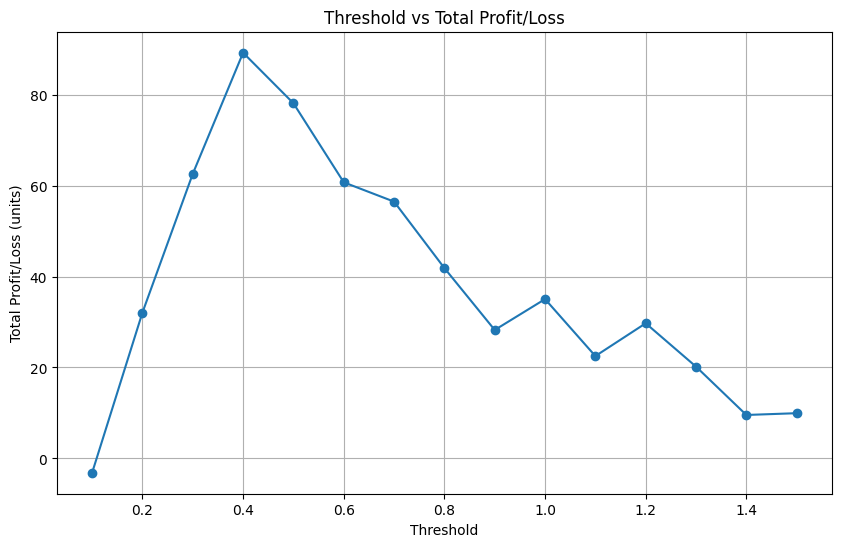


Summary of Threshold Optimization:
    threshold  total_profit_loss
0         0.1          -3.150222
1         0.2          32.077050
2         0.3          62.581118
3         0.4          89.211286
4         0.5          78.095247
5         0.6          60.715006
6         0.7          56.461276
7         0.8          41.851522
8         0.9          28.238663
9         1.0          35.028867
10        1.1          22.502138
11        1.2          29.710842
12        1.3          20.177808
13        1.4           9.549945
14        1.5           9.941404


In [53]:
# Define a range of thresholds to test (e.g., 0.1 to 1.5 in increments of 0.1)
threshold_values = [round(x * 0.1, 1) for x in range(1, 16)]  # [0.1, 0.2, ..., 1.5]
# threshold_values = [round(x * 0.1, 1) for x in range(-15, 16)]  # Tests from -1.5 to 1.5 in 0.1 increments
# Apply the find_optimal_threshold function
threshold_results = find_optimal_threshold(combined_shots_df, thresholds=threshold_values, plot=True)

# Display the summary of results
print("\nSummary of Threshold Optimization:")
print(threshold_results)

In [54]:
combined_shots_df = simulate_bets_directional_thresholds(
    combined_shots_df, 
    threshold_positive=0.6, 
    threshold_negative=0.4
)
combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed'])

C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\3061439293.py:97: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.5882352941176472 ...
 0.606060606060606 0.5494505494505495 0.6493506493506493]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1


,date,player,bet_placed,bet_type,handicap,x_shots_mod,sog,bet_odds,bet_outcome,profit_loss
0,2024-11-01,Sam Bennett,True,Over,2.5,3.13,3.0,1.833333,Win,0.833333
2,2024-11-01,Sam Reinhart,False,None,2.5,2.38,4.0,None,None,0.0
3,2024-11-01,Anton Lundell,True,Over,1.5,2.15,1.0,1.487805,Loss,-1
4,2024-11-01,Aleksander Barkov,True,Under,2.5,1.19,2.0,1.724638,Win,0.724638
5,2024-11-01,Evan Rodrigues,False,None,1.5,1.95,1.0,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...
13252,2024-12-31,Lucas Raymond,True,Under,2.5,1.47,4.0,1.531915,Loss,-1
13255,2024-12-31,Vladimir Tarasenko,False,None,1.5,1.54,0.0,None,None,0.0
13257,2024-12-31,Erik Karlsson,False,None,2.5,2.26,4.0,None,None,0.0
13262,2024-12-31,Sidney Crosby,False,None,2.5,2.86,3.0,None,None,0.0


In [55]:
# Tally the number of Wins and Losses
bet_outcomes = combined_shots_df['bet_outcome'].value_counts()

print("Bet Outcomes Tally:")
print(bet_outcomes)

# Calculate total profit or loss
total_profit_loss = combined_shots_df['profit_loss'].sum()
print(f"\nTotal Profit/Loss from Bets: {total_profit_loss:.2f} units")

Bet Outcomes Tally:
bet_outcome
Win     1315
Loss     861
Name: count, dtype: int64

Total Profit/Loss from Bets: 87.22 units


C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.5882352941176472 ...
 0.6944444444444444 0.6493506493506493 0.6578947368421053]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.5882352941176472 ...
 0.6944444444444444 0.6493506493506493 0.6578947368421053]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipyk

Threshold: -1.5 | Total Profit/Loss: -5.78 units
Threshold: -1.4 | Total Profit/Loss: -5.78 units
Threshold: -1.3 | Total Profit/Loss: -5.78 units
Threshold: -1.2 | Total Profit/Loss: -5.78 units
Threshold: -1.1 | Total Profit/Loss: -5.78 units
Threshold: -1.0 | Total Profit/Loss: -5.78 units
Threshold: -0.9 | Total Profit/Loss: -5.78 units
Threshold: -0.8 | Total Profit/Loss: -5.78 units
Threshold: -0.7 | Total Profit/Loss: -5.78 units
Threshold: -0.6 | Total Profit/Loss: -5.78 units
Threshold: -0.5 | Total Profit/Loss: -5.78 units
Threshold: -0.4 | Total Profit/Loss: -5.78 units
Threshold: -0.3 | Total Profit/Loss: -5.78 units


C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.5882352941176472 ...
 0.6944444444444444 0.6493506493506493 0.6578947368421053]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8333333333333335 0.7246376811594204 0.5882352941176472 ...
 0.6944444444444444 0.6493506493506493 0.6578947368421053]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipyk

Threshold: -0.2 | Total Profit/Loss: -5.78 units
Threshold: -0.1 | Total Profit/Loss: -5.78 units
Threshold: 0.0 | Total Profit/Loss: -5.78 units
Threshold: 0.1 | Total Profit/Loss: -3.15 units
Threshold: 0.2 | Total Profit/Loss: 32.08 units
Threshold: 0.3 | Total Profit/Loss: 62.58 units
Threshold: 0.4 | Total Profit/Loss: 89.21 units
Threshold: 0.5 | Total Profit/Loss: 78.10 units
Threshold: 0.6 | Total Profit/Loss: 60.72 units
Threshold: 0.7 | Total Profit/Loss: 56.46 units
Threshold: 0.8 | Total Profit/Loss: 41.85 units
Threshold: 0.9 | Total Profit/Loss: 28.24 units
Threshold: 1.0 | Total Profit/Loss: 35.03 units
Threshold: 1.1 | Total Profit/Loss: 22.50 units
Threshold: 1.2 | Total Profit/Loss: 29.71 units
Threshold: 1.3 | Total Profit/Loss: 20.18 units
Threshold: 1.4 | Total Profit/Loss: 9.55 units
Threshold: 1.5 | Total Profit/Loss: 9.94 units

Optimal Threshold: 0.4 with Total Profit/Loss: 89.21 units


C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.7246376811594204 0.510204081632653 0.819672131147541 0.5319148936170213
 0.9803921568627452 1.06 0.8 0.5319148936170213 0.5494505494505495
 0.641025641025641 1.04 0.7692307692307692 0.5747126436781609
 0.7142857142857144 0.847457627118644 0.5434782608695652
 0.8771929824561404 0.5050505050505052 0.5882352941176472
 0.7692307692307692 0.7407407407407407 0.625 0.625 0.5882352941176472
 0.5747126436781609 0.925925925925926 0.5747126436781609
 0.8695652173913042 0.6849315068493151 0.5882352941176472
 0.6578947368421053 0.847457627118644 0.625 1.2800000000000002
 0.6097560975609757 0.5494505494505495 0.6493506493506493
 0.7142857142857144 1.1799999999999997 0.5882352941176472
 0.5434782608695652 1.3600000000000003 0.6578947368421053
 0.510204081632653 0.5208333333333335 0.510204081632653 0.7142

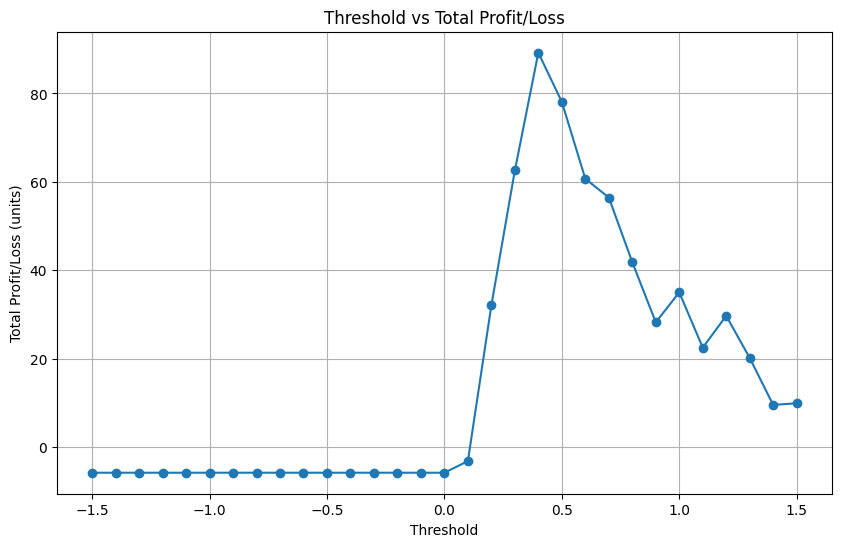


Summary of Threshold Optimization:
    threshold  total_profit_loss
0        -1.5          -5.777590
1        -1.4          -5.777590
2        -1.3          -5.777590
3        -1.2          -5.777590
4        -1.1          -5.777590
5        -1.0          -5.777590
6        -0.9          -5.777590
7        -0.8          -5.777590
8        -0.7          -5.777590
9        -0.6          -5.777590
10       -0.5          -5.777590
11       -0.4          -5.777590
12       -0.3          -5.777590
13       -0.2          -5.777590
14       -0.1          -5.777590
15        0.0          -5.777590
16        0.1          -3.150222
17        0.2          32.077050
18        0.3          62.581118
19        0.4          89.211286
20        0.5          78.095247
21        0.6          60.715006
22        0.7          56.461276
23        0.8          41.851522
24        0.9          28.238663
25        1.0          35.028867
26        1.1          22.502138
27        1.2          29.710842
28     

In [56]:
# Define a range of thresholds to test (e.g., 0.1 to 1.5 in increments of 0.1)
# threshold_values = [round(x * 0.1, 1) for x in range(1, 16)]  # [0.1, 0.2, ..., 1.5]
threshold_values = [round(x * 0.1, 1) for x in range(-15, 16)]  # Tests from -1.5 to 1.5 in 0.1 increments
# Apply the find_optimal_threshold function
threshold_results = find_optimal_threshold(combined_shots_df, thresholds=threshold_values, plot=True)

# Display the summary of results
print("\nSummary of Threshold Optimization:")
print(threshold_results)

In [ ]:
get_player_sog_odds(player_name='Quinn Hughes', query_date='2024-12-01', sportsbook='fanduel', team_name='Vancouver Canucks')

In [48]:
combined_shots_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds,bet_placed,bet_type,bet_odds,bet_outcome,profit_loss,over_decimal_odds,under_decimal_odds
0,2024-11-01,Sam Bennett,FLA,C,11,164.10,14.92,10.60,18.65,14.99,4.97,17.83,3.15,3.13,3.0,2.5,-120.0,-108.0,True,Over,1.833333,Win,0.833333,1.833333,1.925926
2,2024-11-01,Sam Reinhart,FLA,C,11,156.30,14.21,8.45,14.59,12.28,4.74,17.01,2.40,2.38,4.0,2.5,-135.0,104.0,False,None,None,None,0.0,1.740741,2.040000
3,2024-11-01,Anton Lundell,FLA,C,11,152.88,13.90,7.85,12.95,10.20,4.63,16.61,2.17,2.15,1.0,1.5,-205.0,154.0,True,Over,1.487805,Loss,-1,1.487805,2.540000
4,2024-11-01,Aleksander Barkov,FLA,C,3,36.10,12.03,4.99,13.30,11.63,4.01,14.39,1.20,1.19,2.0,2.5,106.0,-138.0,True,Under,1.724638,Win,0.724638,2.060000,1.724638
5,2024-11-01,Evan Rodrigues,FLA,C,11,159.90,14.54,6.75,13.51,9.01,4.85,17.40,1.96,1.95,1.0,1.5,-152.0,116.0,False,None,None,None,0.0,1.657895,2.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13252,2024-12-31,Lucas Raymond,DET,L,36,481.43,13.37,5.36,12.71,9.10,4.46,16.23,1.45,1.47,4.0,2.5,142.0,-188.0,True,Under,1.531915,Loss,-1,2.420000,1.531915
13255,2024-12-31,Vladimir Tarasenko,DET,R,35,433.90,12.40,6.08,12.58,8.85,4.13,15.03,1.52,1.54,0.0,1.5,-144.0,110.0,False,None,None,None,0.0,1.694444,2.100000
13257,2024-12-31,Erik Karlsson,PIT,D,38,716.08,18.84,5.45,15.67,8.13,6.28,23.38,2.12,2.26,4.0,2.5,-104.0,-125.0,False,None,None,None,0.0,1.961538,1.800000
13262,2024-12-31,Sidney Crosby,PIT,C,38,590.57,15.54,8.33,15.95,12.80,5.18,19.28,2.68,2.86,3.0,2.5,-152.0,116.0,False,None,None,None,0.0,1.657895,2.160000


Root Mean Square Error (RMSE): 1.6991
Mean Absolute Error (MAE): 1.3073
R² Score: 0.0177


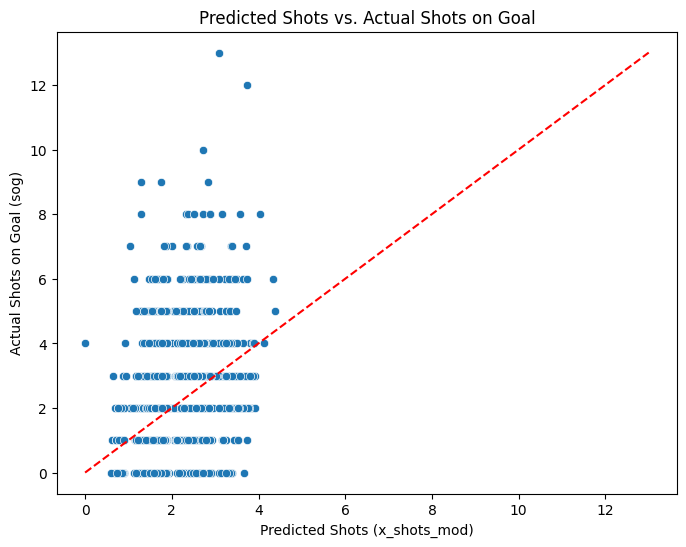

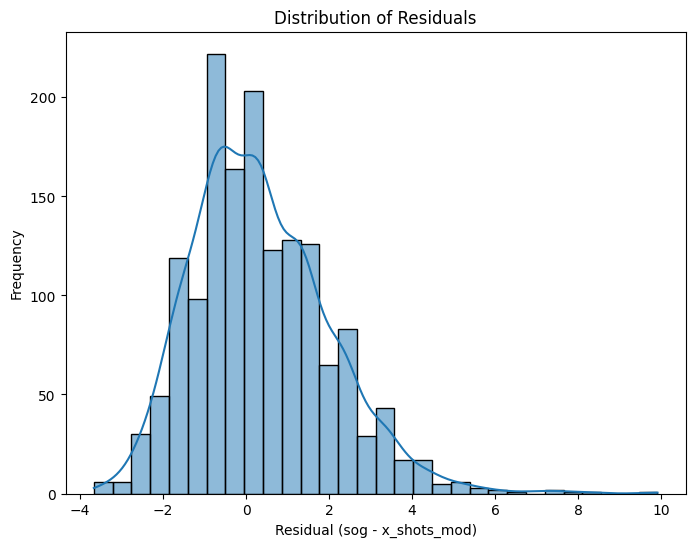

                 player      RMSE
0          Aaron Ekblad  1.238373
1         Adam Fantilli  1.395801
2              Adam Fox  1.130000
3          Adrian Kempe  2.376187
4     Aleksander Barkov  2.057338
..                  ...       ...
234    William Nylander  0.860000
235      Wyatt Johnston  0.840000
236  Yegor Sharangovich  1.241088
237          Zach Hyman  1.014117
238       Zach Werenski  2.295750

[239 rows x 2 columns]


C:\Users\H-100\AppData\Local\Temp\ipykernel_15392\3061046609.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_rmse = data.groupby('player').apply(


In [49]:
from db_utils.prop_odds_db_utils import american_to_decimal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = combined_shots_df.dropna().copy()

# Ensure that the data is a deep copy to avoid SettingWithCopyWarning
data = combined_shots_df.dropna().copy()

# Convert American odds to Decimal odds using .loc
data.loc[:, 'over_decimal_odds'] = data['over_odds'].apply(american_to_decimal)
data.loc[:, 'under_decimal_odds'] = data['under_odds'].apply(american_to_decimal)

# If 'implied_over_prob' and 'implied_under_prob' are no longer needed, you can remove them
# data.loc[:, 'implied_over_prob'] = 1 / data['over_decimal_odds']
# data.loc[:, 'implied_under_prob'] = 1 / data['under_decimal_odds']

# Compare model predictions to actual shots on goal
# Calculate RMSE between model predictions and actual shots on goal
rmse = np.sqrt(mean_squared_error(data['sog'], data['x_shots_mod']))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Calculate MAE for additional insight
mae = mean_absolute_error(data['sog'], data['x_shots_mod'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate R² Score to understand variance explained by the model
r2 = r2_score(data['sog'], data['x_shots_mod'])
print(f"R² Score: {r2:.4f}")

# Optional: Visualize the relationship between predicted and actual shots
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x_shots_mod', y='sog', data=data)
plt.plot([data['sog'].min(), data['sog'].max()], [data['sog'].min(), data['sog'].max()], 'r--')  # Diagonal line
plt.title('Predicted Shots vs. Actual Shots on Goal')
plt.xlabel('Predicted Shots (x_shots_mod)')
plt.ylabel('Actual Shots on Goal (sog)')
plt.show()

# Optional: Residual Analysis
data['residuals'] = data['sog'] - data['x_shots_mod']

plt.figure(figsize=(8, 6))
sns.histplot(data['residuals'], bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (sog - x_shots_mod)')
plt.ylabel('Frequency')
plt.show()

# Optional: Per-Player RMSE
player_rmse = data.groupby('player').apply(
    lambda df: np.sqrt(mean_squared_error(df['sog'], df['x_shots_mod']))
).reset_index(name='RMSE')

print(player_rmse)